In [1]:
import nest_asyncio
nest_asyncio.apply()

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import sys
import time
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
# get_ipython().run_line_magic('matplotlib', 'inline')

sns.color_palette("rocket")
sns.set_style('whitegrid')

In [2]:
# Data    
# Four years' (209 weeks) records of sales, media impression and media spending at weekly level.   
df = pd.read_csv('data.csv')

to_drop_list= ['_sms']
to_drop=[]
for i in to_drop_list:
    aux = [col for col in df.columns if i in col]
    to_drop.extend(aux)
df.drop(to_drop,axis=1,inplace=True) 

# 1. media variables
# media impression
mdip_cols=[col for col in df.columns if 'mdip_' in col]
# media spending
mdsp_cols=[col for col in df.columns if 'mdsp_' in col]

# 2. control variables
# macro economics variables
me_cols = [col for col in df.columns if 'me_' in col]
# store count variables
st_cols = ['st_ct']
# markdown/discount variables
mrkdn_cols = [col for col in df.columns if 'mrkdn_' in col]
# holiday variables
hldy_cols = [col for col in df.columns if 'hldy_' in col]
# seasonality variables
seas_cols = [col for col in df.columns if 'seas_' in col]
base_vars = me_cols+st_cols+mrkdn_cols+hldy_cols+seas_cols

# 3. sales variables
sales_cols =['sales']

#df[['wk_strt_dt']+mdip_cols+['sales']].head()
#df.columns

<AxesSubplot:>

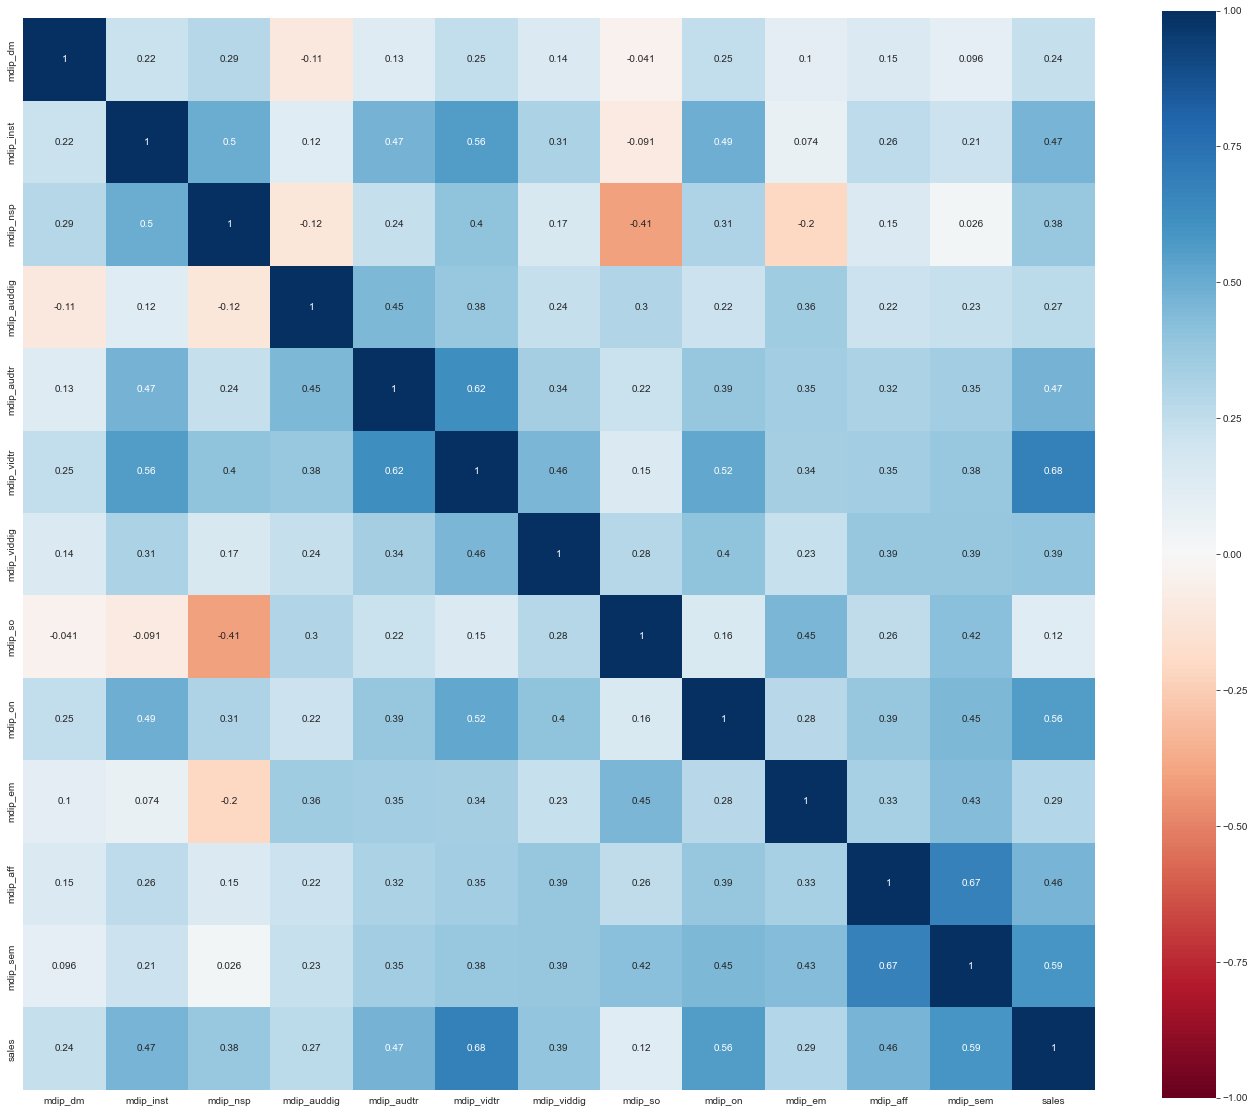

In [3]:
# EDA - correlation, distribution plots
plt.figure(figsize=(24,20))
sns.heatmap(df[mdip_cols+['sales']].corr(), square=True, annot=True, vmax=1, vmin=-1, cmap='RdBu')

<Figure size 3600x3600 with 0 Axes>

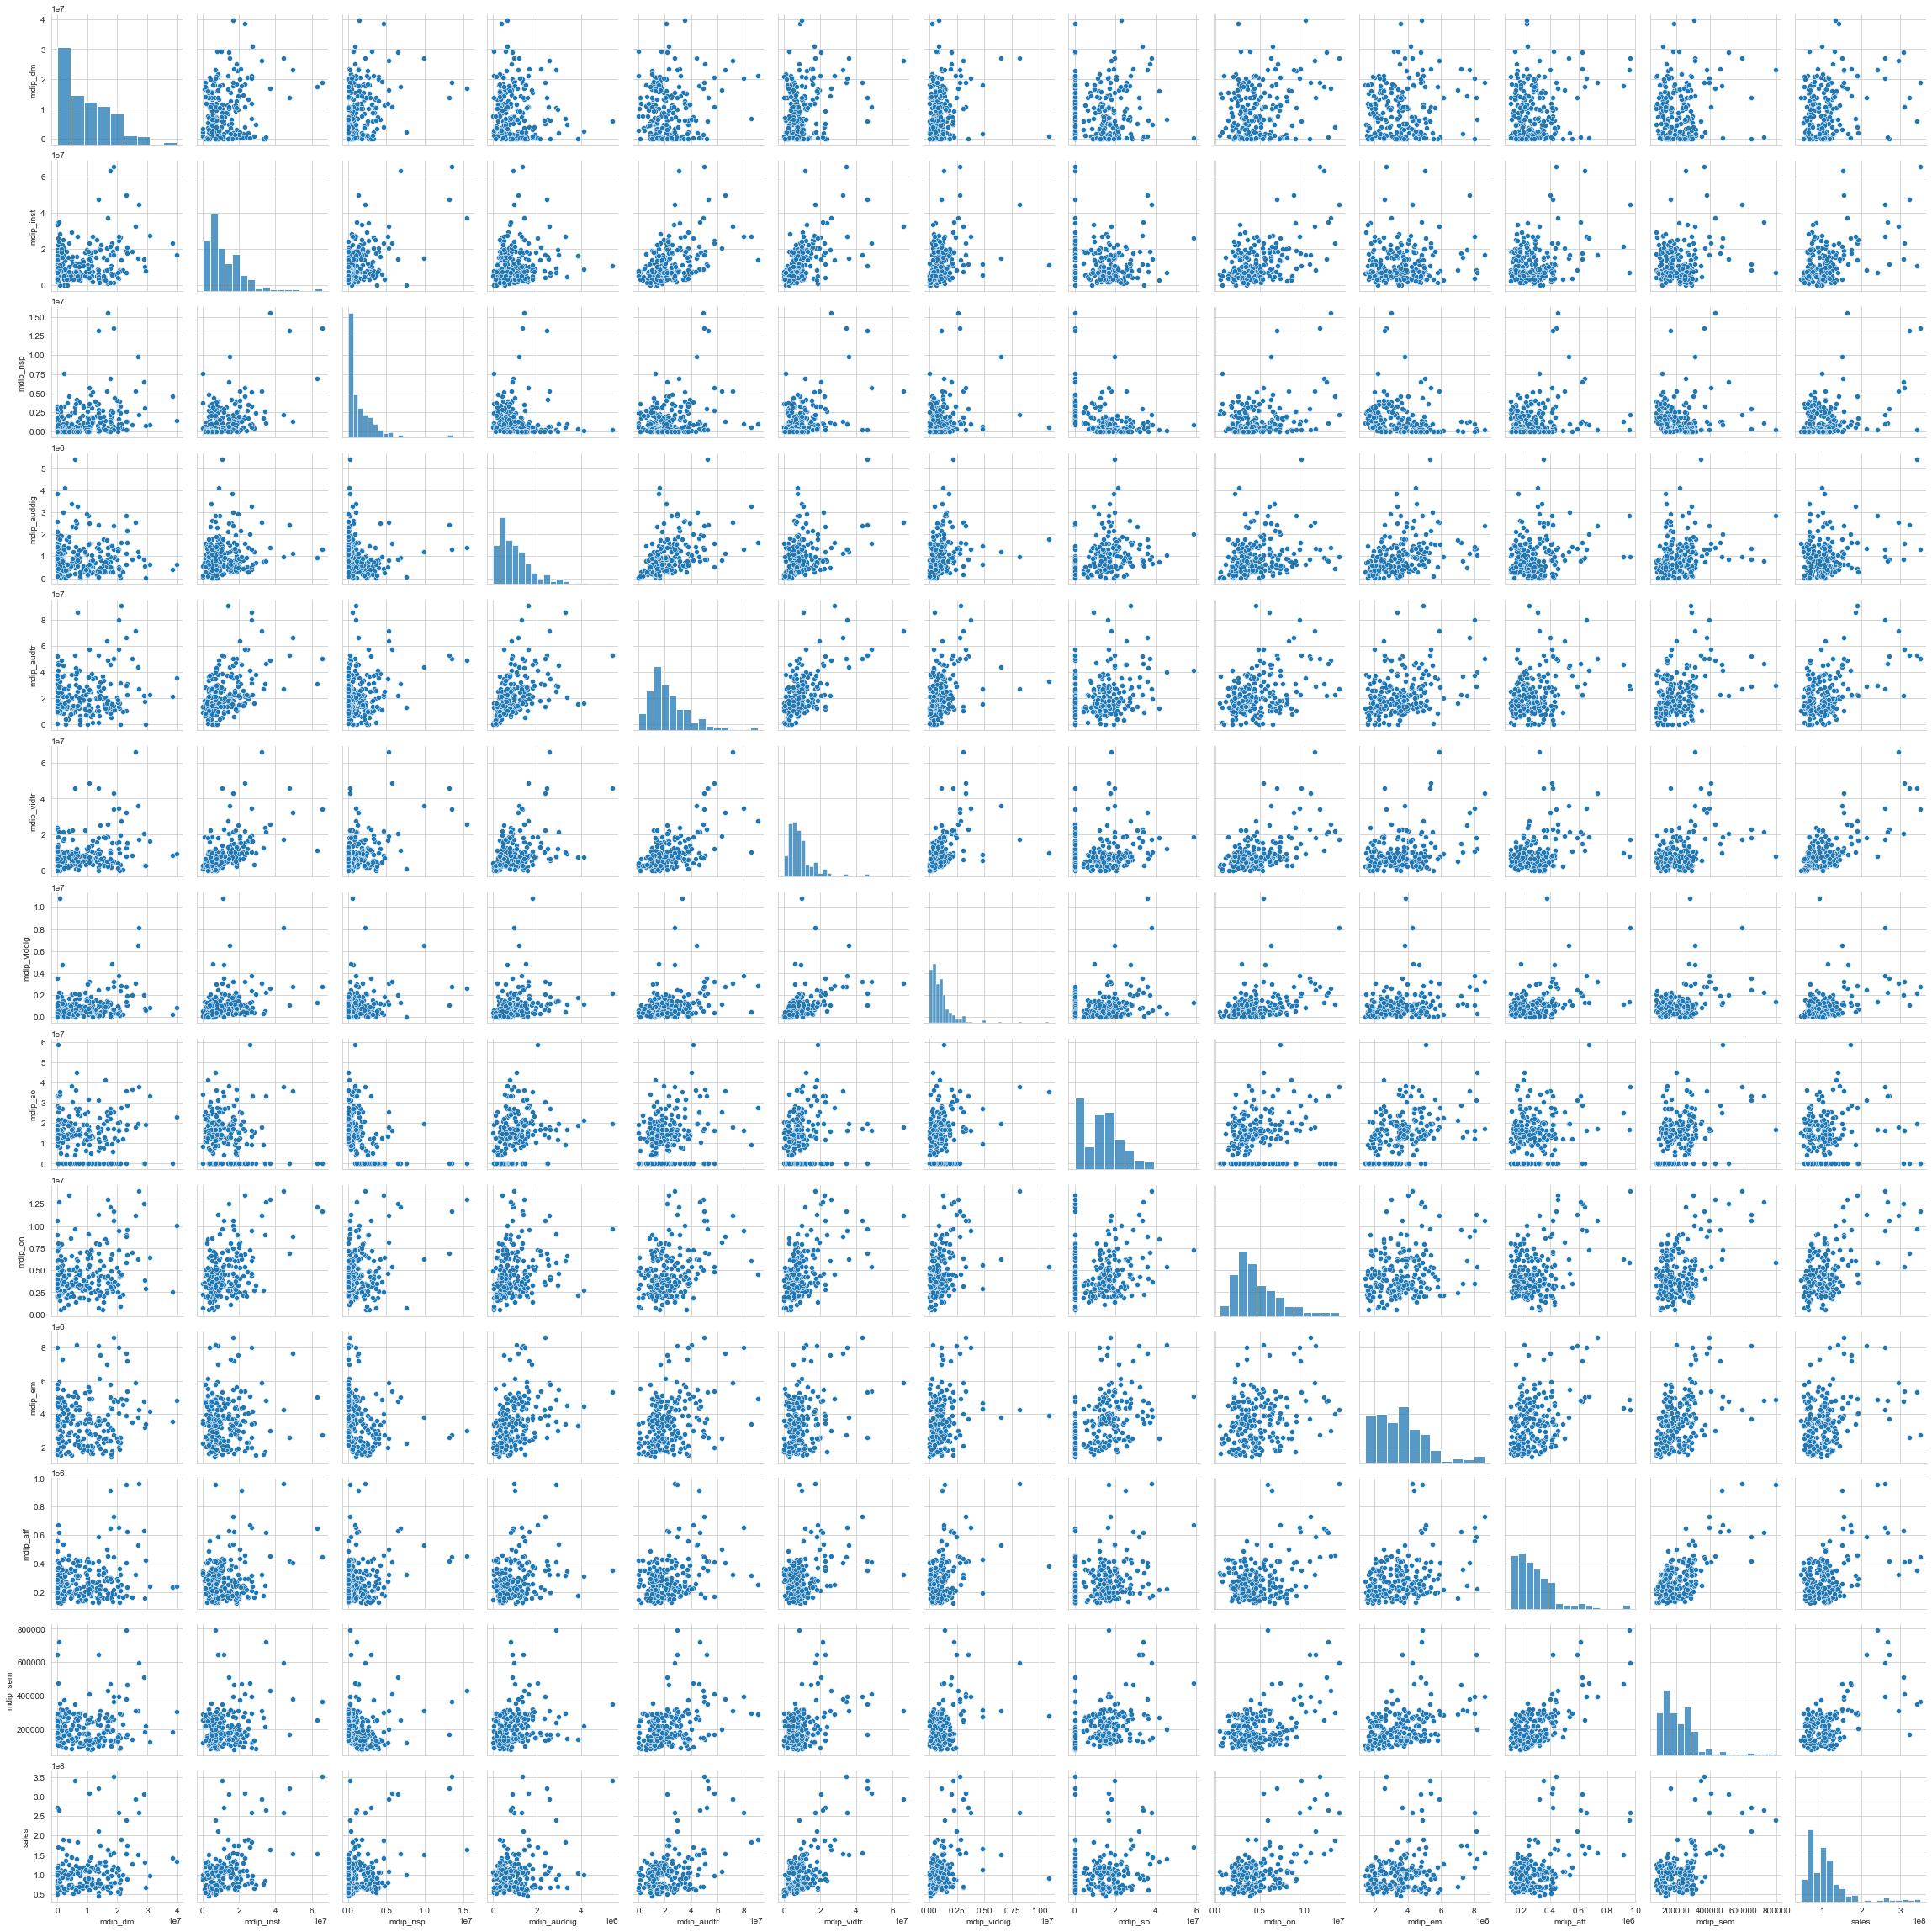

In [4]:
plt.figure(figsize=(50,50))
sns.pairplot(df[mdip_cols+['sales']], vars=mdip_cols+['sales'])

In [161]:
raar = range(7, 209)
for i in raar:
    print(i)

7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208


In [11]:
# 1.1 Adstock
def apply_adstock(x, L, P, D):
    '''
    params:
    x: original media variable, array
    L: length
    P: peak, delay in effect
    D: decay, retain rate
    returns:
    array, adstocked media variable
    '''
    x = np.append(np.zeros(L-1), x)
    
    weights = np.zeros(L)
    for l in range(L):
        weight = D**((l-P)**2)
        weights[L-1-l] = weight
    
    adstocked_x = []
    for i in range(L-1, len(x)):
        x_array = x[i-L+1:i+1]
        xi = sum(x_array * weights)/sum(weights)
        adstocked_x.append(xi)
    adstocked_x = np.array(adstocked_x)
    return adstocked_x

def adstock_transform(df, md_cols, adstock_params):
    '''
    params:
    df: original data
    md_cols: list, media variables to be transformed
    adstock_params: dict, 
        e.g., {'sem': {'L': 8, 'P': 0, 'D': 0.1}, 'dm': {'L': 4, 'P': 1, 'D': 0.7}}
    returns: 
    adstocked df
    '''
    md_df = pd.DataFrame()
    for md_col in md_cols:
        md = md_col.split('_')[-1]
        L, P, D = adstock_params[md]['L'], adstock_params[md]['P'], adstock_params[md]['D']
        xa = apply_adstock(df[md_col].values, L, P, D)
        md_df[md_col] = xa
    return md_df

# 1.2 Diminishing Return
def hill_transform(x, ec, slope):
    return 1 / (1 + (x / ec)**(-slope))

# 2. Model Implementation
# The model is built in a stacked way. Three models are trained:   
# - Control Model
# - Marketing Mix Model
# - Diminishing Return Model    

# 2.1 Control Model / Base Sales Model
import stan
import os
#os.environ['CC'] = 'gcc-10'
#os.environ['CXX'] = 'g++-10'
os.environ['CC'] = 'x86_64-apple-darwin13.4.0-clang'
os.environ['CXX'] = 'x86_64-apple-darwin13.4.0-clang++'


# helper functions
from sklearn.metrics import mean_squared_error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def apply_mean_center(x):
    mu = np.mean(x)
    xm = x/mu
    return xm, mu

def mean_center_trandform(df, cols):
    '''
    returns: 
    mean-centered df
    scaler, dict
    '''
    df_new = pd.DataFrame()
    sc = {}
    for col in cols:
        x = df[col].values
        df_new[col], mu = apply_mean_center(x)
        sc[col] = mu
    return df_new, sc

def mean_log1p_trandform(df, cols):
    '''
    returns: 
    mean-centered, log1p transformed df
    scaler, dict
    '''
    df_new = pd.DataFrame()
    sc = {}
    for col in cols:
        x = df[col].values
        xm, mu = apply_mean_center(x)
        sc[col] = mu
        df_new[col] = np.log1p(xm)
    return df_new, sc

import json

def save_json(data, file_name):
    with open(file_name, 'w') as fp:
        json.dump(data, fp)

def load_json(file_name):
    with open(file_name, 'r') as fp:
        data = json.load(fp)
    return data
     

In [14]:
df_ctrl, sc_ctrl = mean_center_trandform(df, ['sales']+me_cols+st_cols+mrkdn_cols)
sc_ctrl

{'sales': 108054258.25583732,
 'me_ics_all': 93.86602870813397,
 'me_gas_dpg': 2.5701961722488034,
 'st_ct': 658.9801777172249,
 'mrkdn_valadd_edw': 0.3480987979760765,
 'mrkdn_pdm': 0.3374485067894737}

In [22]:
len(pn_vars)

19

In [67]:
# mean-centralize: sales, numeric base_vars
df_ctrl, sc_ctrl = mean_center_trandform(df, ['sales']+me_cols+st_cols+mrkdn_cols)
df_ctrl = pd.concat([df_ctrl, df[hldy_cols+seas_cols]], axis=1)

# variables positively related to sales: macro economy, store count, markdown, holiday
pos_vars = [col for col in base_vars if col not in seas_cols]
X1 = df_ctrl[pos_vars].values

# variables may have either positive or negtive impact on sales: seasonality
pn_vars = seas_cols
X2 = df_ctrl[pn_vars].values

ctrl_data = {
    'N': len(df_ctrl),
    'K1': len(pos_vars), 
    'K2': len(pn_vars), 
    'X1': X1,
    'X2': X2, 
    'y': df_ctrl['sales'].values,
    'max_intercept': min(df_ctrl['sales'])
}

ctrl_code1 = '''
data {
  int N; // number of observations
  int K1; // number of positive predictors
  int K2; // number of positive/negative predictors
  real max_intercept; // restrict the intercept to be less than the minimum y
  matrix[N, K1] X1;
  matrix[N, K2] X2;
  vector[N] y; 
}

parameters {
  vector[K1] beta1; // regression coefficients for X1 (positive)
  vector[K2] beta2; // regression coefficients for X2
  real alpha; // intercept
  real noise_var; // residual variance
}

model {
  // Define the priors
  beta1 ~ normal(0, 1); 
  beta2 ~ normal(0, 1); 
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01);
  // The likelihood
  y ~ normal(X1*beta1 + X2*beta2 + alpha, sqrt(noise_var));
}
'''


In [68]:
sm1 = stan.build(ctrl_code1, data=ctrl_data)
fit1 = sm1.sample(num_chains=2, num_samples=4000)
fit1_result = fit1.to_frame()

Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_n3mn2qz0/model_kxnlkyhh.stan', line 23, column 30: Argument
    0.0005 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_n3mn2qz0/model_kxnlkyhh.stan', line 23, column 24: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_n3mn2qz0/model_kxnlkyhh.stan', line 23, column 2: Parameter
    noise_var is given a inv_gamma distribution, which has strictly positive
    support, but noise_var was not constrained to be strictly positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is nan, but must be positive! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_8jclci6_/model_kxnlkyhh.stan', line 25, column 2 to column 59)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is nan, but must be positive! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_8jclci6_/model_kxnlkyhh.stan', line 25, column 2 to column 59)
  If this warning occurs sp

In [64]:
fit1_result.columns

Index(['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__',
       'divergent__', 'energy__', 'beta1.1', 'beta1.2', 'beta1.3', 'beta1.4',
       'beta1.5', 'beta1.6', 'beta1.7', 'beta1.8', 'beta1.9', 'beta1.10',
       'beta1.11', 'beta1.12', 'beta1.13', 'beta1.14', 'beta1.15', 'beta1.16',
       'beta1.17', 'beta1.18', 'beta1.19', 'beta1.20', 'beta1.21', 'beta1.22',
       'beta1.23', 'beta1.24', 'beta1.25', 'beta1.26', 'beta1.27', 'beta2.1',
       'beta2.2', 'beta2.3', 'beta2.4', 'beta2.5', 'beta2.6', 'beta2.7',
       'beta2.8', 'beta2.9', 'beta2.10', 'beta2.11', 'beta2.12', 'beta2.13',
       'beta2.14', 'beta2.15', 'beta2.16', 'beta2.17', 'beta2.18', 'beta2.19',
       'alpha', 'noise_var'],
      dtype='object', name='parameters')

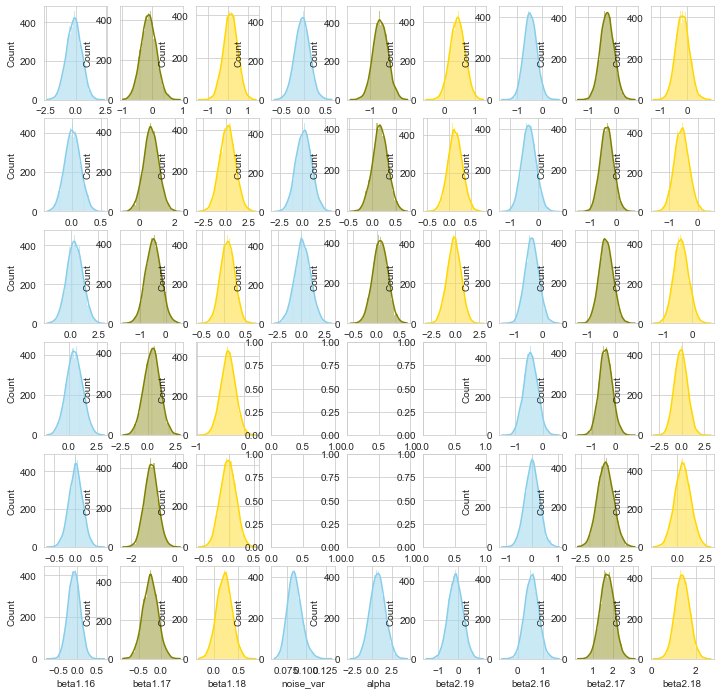

In [69]:
fig, axs = plt.subplots(6, 9, figsize=(12, 12))

sns.histplot(data=fit1_result, x="beta1.1", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=fit1_result, x="beta1.2", kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=fit1_result, x="beta1.3", kde=True, color="gold", ax=axs[0, 2])
sns.histplot(data=fit1_result, x="beta1.4", kde=True, color="skyblue", ax=axs[1, 0])
sns.histplot(data=fit1_result, x="beta1.5", kde=True, color="olive", ax=axs[1, 1])
sns.histplot(data=fit1_result, x="beta1.6", kde=True, color="gold", ax=axs[1, 2])
sns.histplot(data=fit1_result, x="beta1.7", kde=True, color="skyblue", ax=axs[2, 0])
sns.histplot(data=fit1_result, x="beta1.8", kde=True, color="olive", ax=axs[2, 1])
sns.histplot(data=fit1_result, x="beta1.9", kde=True, color="gold", ax=axs[2, 2])

sns.histplot(data=fit1_result, x="beta1.10", kde=True, color="skyblue", ax=axs[3, 0])
sns.histplot(data=fit1_result, x="beta1.11", kde=True, color="olive", ax=axs[3, 1])
sns.histplot(data=fit1_result, x="beta1.12", kde=True, color="gold", ax=axs[3, 2])
sns.histplot(data=fit1_result, x="beta1.13", kde=True, color="skyblue", ax=axs[4, 0])
sns.histplot(data=fit1_result, x="beta1.14", kde=True, color="olive", ax=axs[4, 1])
sns.histplot(data=fit1_result, x="beta1.15", kde=True, color="gold", ax=axs[4, 2])
sns.histplot(data=fit1_result, x="beta1.16", kde=True, color="skyblue", ax=axs[5, 0])
sns.histplot(data=fit1_result, x="beta1.17", kde=True, color="olive", ax=axs[5, 1])
sns.histplot(data=fit1_result, x="beta1.18", kde=True, color="gold", ax=axs[5, 2])


sns.histplot(data=fit1_result, x="beta1.19", kde=True, color="skyblue", ax=axs[0, 3])
sns.histplot(data=fit1_result, x="beta1.20", kde=True, color="olive", ax=axs[0, 4])
sns.histplot(data=fit1_result, x="beta1.21", kde=True, color="gold", ax=axs[0, 5])
sns.histplot(data=fit1_result, x="beta1.22", kde=True, color="skyblue", ax=axs[1, 3])
sns.histplot(data=fit1_result, x="beta1.23", kde=True, color="olive", ax=axs[1, 4])
sns.histplot(data=fit1_result, x="beta1.24", kde=True, color="gold", ax=axs[1, 5])
sns.histplot(data=fit1_result, x="beta1.25", kde=True, color="skyblue", ax=axs[2, 3])
sns.histplot(data=fit1_result, x="beta1.26", kde=True, color="olive", ax=axs[2, 4])
sns.histplot(data=fit1_result, x="beta1.27", kde=True, color="gold", ax=axs[2, 5])


sns.histplot(data=fit1_result, x="beta2.1", kde=True, color="skyblue", ax=axs[0, 6])
sns.histplot(data=fit1_result, x="beta2.2", kde=True, color="olive", ax=axs[0, 7])
sns.histplot(data=fit1_result, x="beta2.3", kde=True, color="gold", ax=axs[0, 8])
sns.histplot(data=fit1_result, x="beta2.4", kde=True, color="skyblue", ax=axs[1, 6])
sns.histplot(data=fit1_result, x="beta2.5", kde=True, color="olive", ax=axs[1, 7])
sns.histplot(data=fit1_result, x="beta2.6", kde=True, color="gold", ax=axs[1, 8])
sns.histplot(data=fit1_result, x="beta2.7", kde=True, color="skyblue", ax=axs[2, 6])
sns.histplot(data=fit1_result, x="beta2.8", kde=True, color="olive", ax=axs[2, 7])
sns.histplot(data=fit1_result, x="beta2.9", kde=True, color="gold", ax=axs[2, 8])

sns.histplot(data=fit1_result, x="beta2.10", kde=True, color="skyblue", ax=axs[3, 6])
sns.histplot(data=fit1_result, x="beta2.11", kde=True, color="olive", ax=axs[3, 7])
sns.histplot(data=fit1_result, x="beta2.12", kde=True, color="gold", ax=axs[3, 8])
sns.histplot(data=fit1_result, x="beta2.13", kde=True, color="skyblue", ax=axs[4, 6])
sns.histplot(data=fit1_result, x="beta2.14", kde=True, color="olive", ax=axs[4, 7])
sns.histplot(data=fit1_result, x="beta2.15", kde=True, color="gold", ax=axs[4, 8])
sns.histplot(data=fit1_result, x="beta2.16", kde=True, color="skyblue", ax=axs[5, 6])
sns.histplot(data=fit1_result, x="beta2.17", kde=True, color="olive", ax=axs[5, 7])
sns.histplot(data=fit1_result, x="beta2.18", kde=True, color="gold", ax=axs[5, 8])


sns.histplot(data=fit1_result, x="beta2.19", kde=True, color="skyblue", ax=axs[5, 5])
sns.histplot(data=fit1_result, x="alpha", kde=True, color="skyblue", ax=axs[5, 4])
sns.histplot(data=fit1_result, x="noise_var", kde=True, color="skyblue", ax=axs[5, 3])

plt.show()

In [70]:
# extract control model parameters and predict base sales -> df['base_sales']
def extract_ctrl_model(fit_result, pos_vars=pos_vars, pn_vars=pn_vars, 
                       extract_param_list=False):
    ctrl_model = {}
    
    beta1_cols=[col for col in fit1_result.columns if 'beta1' in col]
    beta2_cols=[col for col in fit1_result.columns if 'beta2' in col]

    ctrl_model['pos_vars'] = pos_vars
    ctrl_model['pn_vars'] = pn_vars
    ctrl_model['beta1'] = fit_result[beta1_cols].mean(axis=0).tolist()
    ctrl_model['beta2'] = fit_result[beta2_cols].mean(axis=0).tolist()
    ctrl_model['alpha'] = fit_result['alpha'].mean()
    if extract_param_list:
        ctrl_model['beta1_list'] = fit_result[beta1_cols].tolist()
        ctrl_model['beta2_list'] = fit_result[beta2_cols].tolist()
        ctrl_model['alpha_list'] = fit_result['alpha_cols'].tolist()
    return ctrl_model

def ctrl_model_predict(ctrl_model, df):
    pos_vars, pn_vars = ctrl_model['pos_vars'], ctrl_model['pn_vars'] 
    X1, X2 = df[pos_vars], df[pn_vars]
    beta1, beta2 = np.array(ctrl_model['beta1']), np.array(ctrl_model['beta2'])
    alpha = ctrl_model['alpha']
    y_pred = np.dot(X1, beta1) + np.dot(X2, beta2) + alpha
    return y_pred

base_sales_model = extract_ctrl_model(fit1_result, pos_vars=pos_vars, pn_vars=pn_vars)
base_sales = ctrl_model_predict(base_sales_model, df_ctrl)
df['base_sales'] = base_sales*sc_ctrl['sales']
# evaluate control model
print('mape: ', mean_absolute_percentage_error(df['sales'], df['base_sales']))

# np.savetxt("base_sales_pred.csv", df['base_sales'].values, delimiter=",")
# save_json(base_sales_model, 'ctrl_model.json')
# df['base_sales'] = pd.read_csv('base_sales_pred.csv', header=None).values

mape:  24.37883689779642


In [71]:
base_sales_model

{'pos_vars': ['me_ics_all',
  'me_gas_dpg',
  'st_ct',
  'mrkdn_valadd_edw',
  'mrkdn_pdm',
  'hldy_Black Friday',
  'hldy_Christmas Day',
  'hldy_Christmas Eve',
  'hldy_Columbus Day',
  'hldy_Cyber Monday',
  'hldy_Day after Christmas',
  'hldy_Easter',
  "hldy_Father's Day",
  'hldy_Green Monday',
  'hldy_July 4th',
  'hldy_Labor Day',
  'hldy_MLK',
  'hldy_Memorial Day',
  "hldy_Mother's Day",
  'hldy_NYE',
  "hldy_New Year's Day",
  'hldy_Pre Thanksgiving',
  'hldy_Presidents Day',
  'hldy_Prime Day',
  'hldy_Thanksgiving',
  "hldy_Valentine's Day",
  'hldy_Veterans Day'],
 'pn_vars': ['seas_prd_1',
  'seas_prd_2',
  'seas_prd_3',
  'seas_prd_4',
  'seas_prd_5',
  'seas_prd_6',
  'seas_prd_7',
  'seas_prd_8',
  'seas_prd_9',
  'seas_prd_12',
  'seas_week_40',
  'seas_week_41',
  'seas_week_42',
  'seas_week_43',
  'seas_week_44',
  'seas_week_45',
  'seas_week_46',
  'seas_week_47',
  'seas_week_48'],
 'beta1': [-0.13407866146183825,
  -0.12018597110509416,
  0.12441775665069277,


In [145]:
df.columns

Index(['wk_strt_dt', 'yr_nbr', 'qtr_nbr', 'prd', 'wk_nbr', 'wk_in_yr_nbr',
       'mdip_dm', 'mdip_inst', 'mdip_nsp', 'mdip_auddig', 'mdip_audtr',
       'mdip_vidtr', 'mdip_viddig', 'mdip_so', 'mdip_on', 'mdip_em',
       'mdip_aff', 'mdip_sem', 'mdsp_dm', 'mdsp_inst', 'mdsp_nsp',
       'mdsp_auddig', 'mdsp_audtr', 'mdsp_vidtr', 'mdsp_viddig', 'mdsp_so',
       'mdsp_on', 'mdsp_sem', 'sales', 'me_ics_all', 'me_gas_dpg', 'st_ct',
       'mrkdn_valadd_edw', 'mrkdn_pdm', 'va_pub_0.15', 'va_pub_0.2',
       'va_pub_0.25', 'va_pub_0.3', 'hldy_Black Friday', 'hldy_Christmas Day',
       'hldy_Christmas Eve', 'hldy_Columbus Day', 'hldy_Cyber Monday',
       'hldy_Day after Christmas', 'hldy_Easter', 'hldy_Father's Day',
       'hldy_Green Monday', 'hldy_July 4th', 'hldy_Labor Day', 'hldy_MLK',
       'hldy_Memorial Day', 'hldy_Mother's Day', 'hldy_NYE',
       'hldy_New Year's Day', 'hldy_Pre Thanksgiving', 'hldy_Presidents Day',
       'hldy_Prime Day', 'hldy_Thanksgiving', 'hldy_Valentine

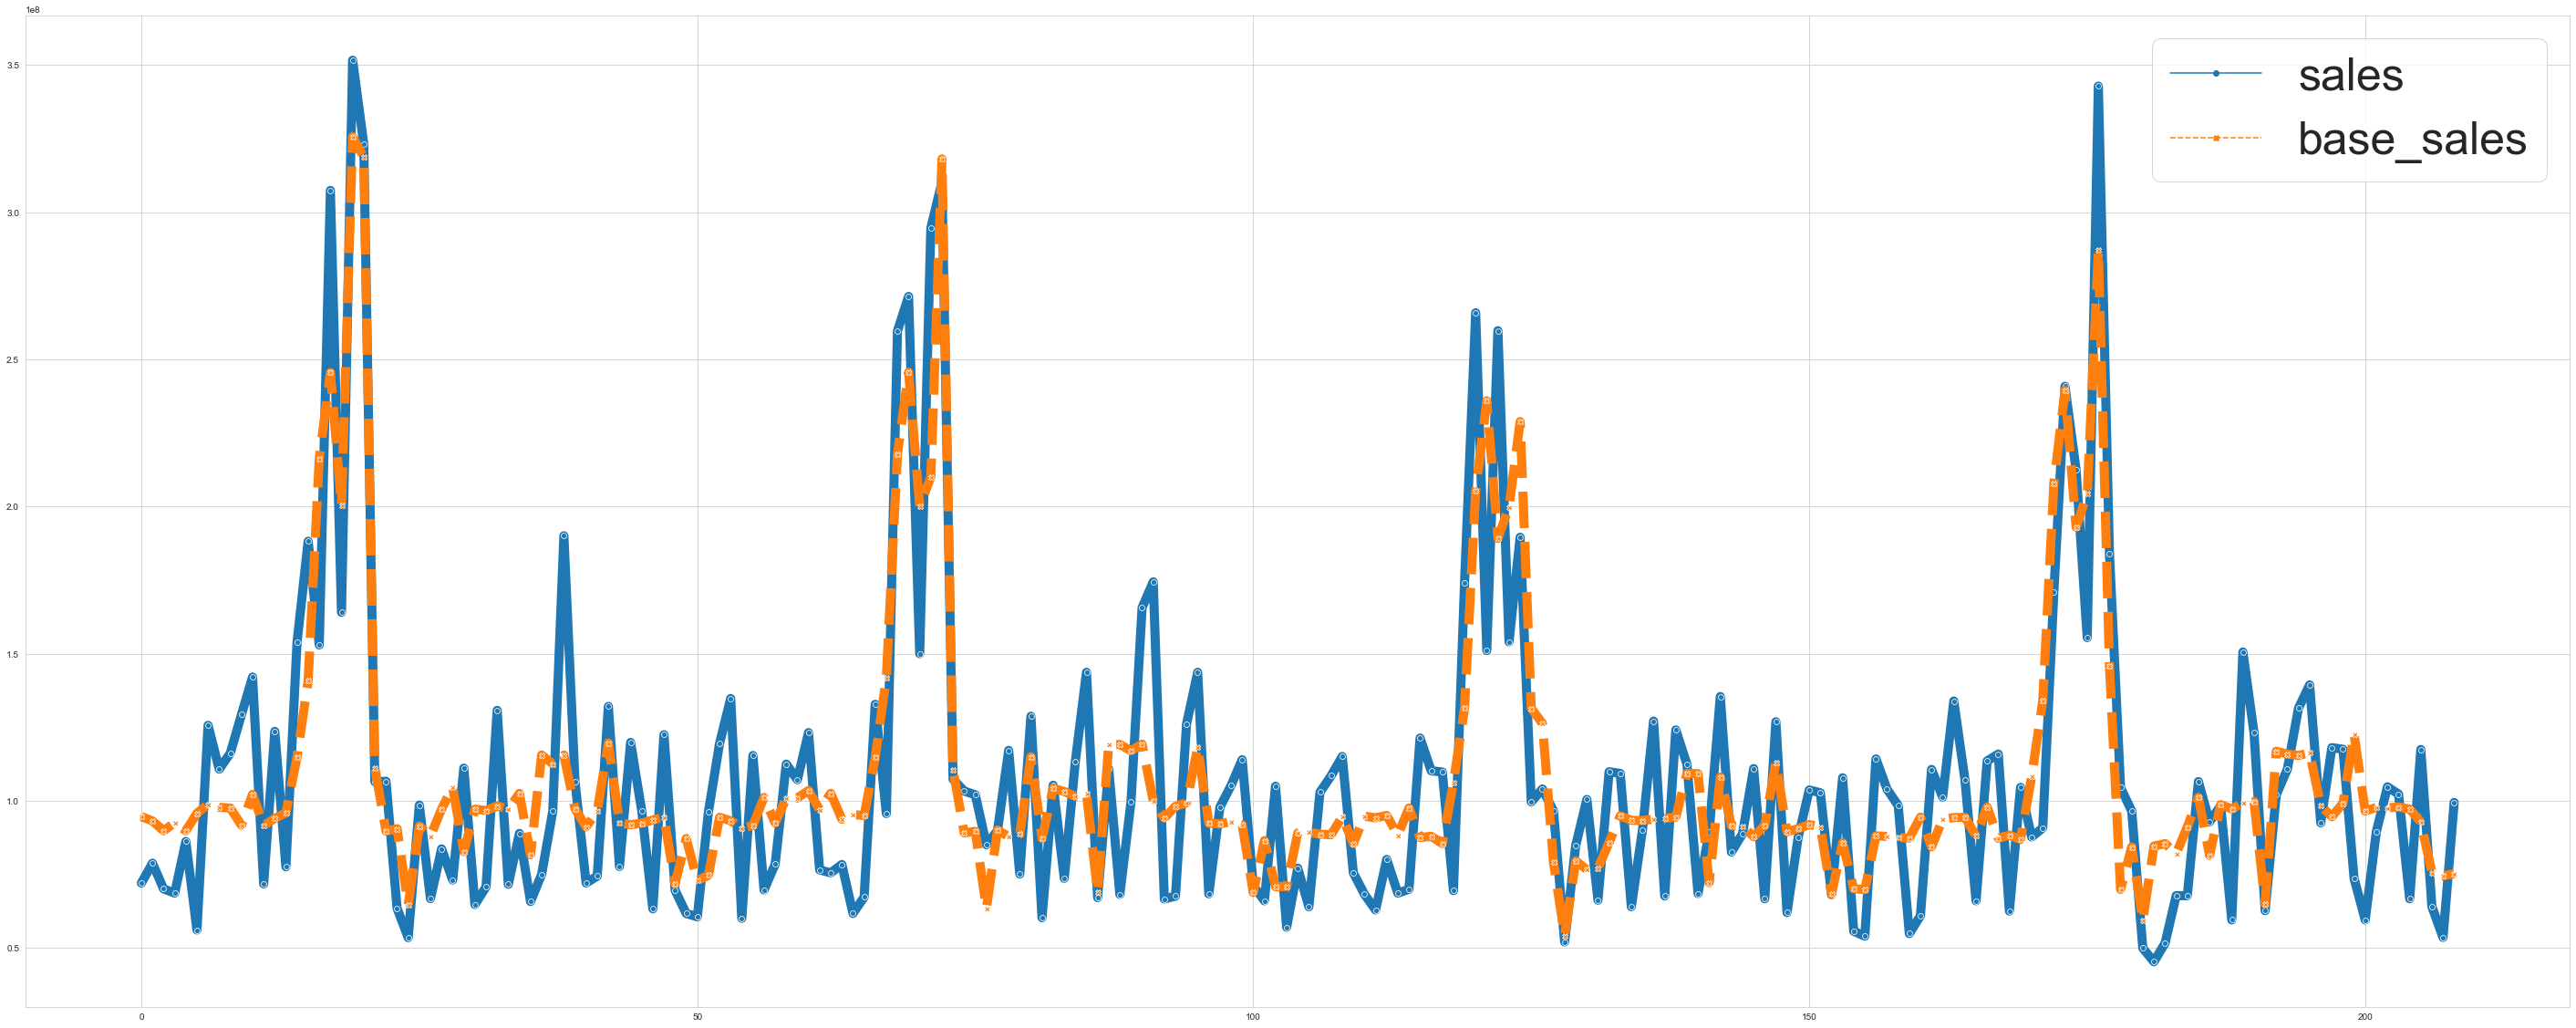

In [73]:
df1_plot = df[['wk_strt_dt','sales','base_sales']]
plt.figure(figsize=(50,20))
sns.lineplot(data=df1_plot,markers=True, dashes=True, linewidth=10)
plt.legend(fontsize='50')

In [80]:
# 2.2 Marketing Mix Model
df_mmm, sc_mmm = mean_log1p_trandform(df, ['sales', 'base_sales'])
mu_mdip = df[mdip_cols].apply(np.mean, axis=0).values
max_lag = 8
num_media = len(mdip_cols)
# padding zero * (max_lag-1) rows
X_media = np.concatenate((np.zeros((max_lag-1, num_media)), df[mdip_cols].values), axis=0)
X_ctrl = df_mmm['base_sales'].values.reshape(len(df),1)
model_data2 = {
    'N': len(df),
    'max_lag': max_lag, 
    'num_media': num_media,
    'X_media': X_media, 
    'mu_mdip': mu_mdip,
    'num_ctrl': X_ctrl.shape[1],
    'X_ctrl': X_ctrl, 
    'y': df_mmm['sales'].values
}

model_code2 = '''
functions {
  // the adstock transformation with a vector of weights
  real Adstock(vector t, row_vector weights) {
    return dot_product(t, weights) / sum(weights);
  }
}
data {

  // the total number of observations  
  int N;  
  // the vector of sales  
  real y[N];  
  // the maximum duration of lag effect, in weeks  
  int max_lag;  
  // the number of media channels  
  int num_media;  
  // matrix of media variables  
  matrix[N+max_lag-1, num_media] X_media;  
  // vector of media variables' mean  
  real mu_mdip[num_media];  
  // the number of other control variables  
  int num_ctrl;  
  // a matrix of control variables  
  matrix[N, num_ctrl] X_ctrl;

}
parameters {
  // residual variance
  real<lower=0> noise_var;
  // the intercept
  real tau;
  // the coefficients for media variables and base sales
  vector<lower=0>[num_media+num_ctrl] beta;
  // the decay and peak parameter for the adstock transformation of
  // each media
  vector<lower=0,upper=1>[num_media] decay;
  vector<lower=0,upper=ceil(max_lag/2)>[num_media] peak;
  
}

transformed parameters {
  // the cumulative media effect after adstock
  real cum_effect;
  
  // matrix of media variables after adstock
  matrix[N, num_media] X_media_adstocked;
  
  // matrix of all predictors
  matrix[N, num_media+num_ctrl] X;
  
  // adstock, mean-center, log1p transformation
  row_vector[max_lag] lag_weights;
  
  for (nn in 1:N) {
    for (media in 1 : num_media) {
      for (lag in 1 : max_lag) {
        lag_weights[max_lag-lag+1] = pow(decay[media], (lag - 1 - peak[media]) ^ 2);
      }
     cum_effect = Adstock(sub_col(X_media, nn, media, max_lag), lag_weights);
     X_media_adstocked[nn, media] = log1p(cum_effect/mu_mdip[media]);
    }
  X = append_col(X_media_adstocked, X_ctrl);
  } 
}

model {
  decay ~ beta(3,3);
  peak ~ uniform(1,ceil(max_lag/2));
  tau ~ normal(0, 5);
  for (i in 1 : num_media+num_ctrl) {
    beta[i] ~ normal(0,1);
  }
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01);
  y ~ normal(tau + X * beta, sqrt(noise_var));
}
'''

In [81]:
sm2 = stan.build(model_code2, data=model_data2)
fit2 = sm2.sample(num_chains=2, num_samples=4000)
fit2_result = fit2.to_frame()
fit2_result.describe().T

Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s


In file included from /Users/rolandoanzola/Library/Caches/httpstan/4.9.1/models/towh6iqe/model_towh6iqe.cpp:2:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:10:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/chainable_object.hpp:6:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/typedefs.hpp:7:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/

Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s


In file included from /Users/rolandoanzola/Library/Caches/httpstan/4.9.1/models/towh6iqe/model_towh6iqe.cpp:2:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
                           [a, b, digamma_ab](auto& vi) mutable {
                             ~~^


Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s


In file included from /Users/rolandoanzola/Library/Caches/httpstan/4.9.1/models/towh6iqe/model_towh6iqe.cpp:2:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/m

Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 7.0s
Building: 7.1s
Building: 7.3s
Building: 7.4s
Building: 7.5s
Building: 7.6s
Building: 7.7s
Building: 7.8s
Building: 7.9s
Building: 8.0s
Building: 8.1s
Building: 8.2s
Building: 8.3s
Building: 8.4s
Building: 8.5s
Building: 8.6s
Building: 8.7s
Building: 8.8s
Building: 8.9s
Building: 9.0s


In file included from /Users/rolandoanzola/Library/Caches/httpstan/4.9.1/models/towh6iqe/model_towh6iqe.cpp:2:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:198:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:14:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/integrate_ode_rk45.hpp:6:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/inclu

Building: 9.1s
Building: 9.2s
Building: 9.3s
Building: 9.4s
Building: 9.5s
Building: 9.6s
Building: 9.7s
Building: 9.8s
Building: 9.9s
Building: 10.0s


In file included from /Users/rolandoanzola/Library/Caches/httpstan/4.9.1/models/towh6iqe/model_towh6iqe.cpp:2:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:128:
/Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/gaussian_dlm_obs_rng.hpp:98:7: warning: unused variable 'n' [-Wunused-variable]
  int n = G.rows();  // number of states
      ^


Building: 10.1s
Building: 10.2s
Building: 10.3s
Building: 10.4s
Building: 10.6s


In file included from /Users/rolandoanzola/Library/Caches/httpstan/4.9.1/models/towh6iqe/model_towh6iqe.cpp:2:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:210:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/multi_student_t_log.hpp:5:
/Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/multi_s

Building: 10.7s
Building: 10.8s
Building: 10.9s


In file included from /Users/rolandoanzola/Library/Caches/httpstan/4.9.1/models/towh6iqe/model_towh6iqe.cpp:2:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:312:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/skew_double_exponential_ccdf_log.hpp:5:
/Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim

Building: 11.0s
Building: 11.1s
Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s


/Users/rolandoanzola/Library/Caches/httpstan/4.9.1/models/towh6iqe/model_towh6iqe.cpp:576:11: warning: variable 'pos__' set but not used [-Wunused-but-set-variable]
      int pos__ = std::numeric_limits<int>::min();
          ^


Building: 11.6s
Building: 11.7s
Building: 11.8s
Building: 11.9s
Building: 12.0s
Building: 12.1s
Building: 12.2s
Building: 12.3s
Building: 12.4s
Building: 12.5s


In file included from /Users/rolandoanzola/Library/Caches/httpstan/4.9.1/models/towh6iqe/model_towh6iqe.cpp:2:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/m

Building: 12.6s
Building: 12.7s
Building: 12.8s
Building: 12.9s
Building: 13.0s
Building: 13.1s


/Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:192:12: warning: unused variable 'pre_mult' [-Wunused-variable]
      auto pre_mult = a2 * pow(1 - z, -1 - a2);
           ^
/Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:307:20: note: in instantiation of function template specialization 'stan::math::internal::grad_2F1_impl<true, true, true, true, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, std::tuple<stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>>>' requested here
  return internal::grad_2F1_impl<true, true, true, true>(a1, a2, b1, z,
                   ^
In file included from /Users/rolandoanzola/Library/Caches/httpstan/4.9.1/models/towh6iqe/model_towh6iqe.cpp:2:
In file incl

Building: 13.2s
Building: 13.3s
Building: 13.4s
Building: 13.5s
Building: 13.6s
Building: 13.7s
Building: 13.8s
Building: 14.0s
Building: 14.1s
Building: 14.2s
Building: 14.3s
Building: 14.4s
Building: 14.5s
Building: 14.6s
Building: 14.7s
Building: 14.8s
Building: 14.9s
Building: 15.0s
Building: 15.1s


In file included from /Users/rolandoanzola/Library/Caches/httpstan/4.9.1/models/towh6iqe/model_towh6iqe.cpp:2:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:100:
/Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/lb_constrain.hpp:114:33: warning: lambda capture 'lp' is not used [-Wunused-lambda-capture]
                               [lp, arena_lb = var(lb)](auto& vi) mutable {
                                ^
/Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/sta

Building: 15.2s
Building: 15.3s


In file included from /Users/rolandoanzola/Library/Caches/httpstan/4.9.1/models/towh6iqe/model_towh6iqe.cpp:2:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:126:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/lub_constrain.hpp:8:
/Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/ub_constrain.hpp:217:35: warning: lambda capture 'lp' is not used [-Wunused-lambda-capture]
      reverse_pass_callback([ret, lp, arena_ub = var

Building: 15.4s
Building: 15.5s
Building: 15.6s


In file included from /Users/rolandoanzola/Library/Caches/httpstan/4.9.1/models/towh6iqe/model_towh6iqe.cpp:2:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:126:
In file included from /Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/lub_constrain.hpp:8:
/Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/ub_constrain.hpp:217:35: warning: lambda capture 'lp' is not used [-Wunused-lambda-capture]
      reverse_pass_callback([ret, lp, arena_ub = var

Building: 15.7s
Building: 15.8s
Building: 15.9s
Building: 16.0s
Building: 16.1s
Building: 16.2s
Building: 16.3s
Building: 16.4s
Building: 16.5s
Building: 16.6s
Building: 16.7s
Building: 16.8s
Building: 16.9s
Building: 17.1s
Building: 17.2s
Building: 17.3s
Building: 17.4s
Building: 17.5s
Building: 17.6s
Building: 17.7s
Building: 17.8s
Building: 17.9s
Building: 18.0s
Building: 18.1s
Building: 18.2s
Building: 18.3s
Building: 18.4s
Building: 18.5s
Building: 18.6s
Building: 18.7s
Building: 18.8s
Building: 18.9s
Building: 19.0s
Building: 19.1s
Building: 19.2s
Building: 19.3s
Building: 19.4s
Building: 19.5s
Building: 19.6s
Building: 19.7s
Building: 19.8s
Building: 19.9s
Building: 20.0s
Building: 20.1s
Building: 20.2s
Building: 20.3s
Building: 20.4s
Building: 20.5s
Building: 20.7s
Building: 20.8s
Building: 20.9s
Building: 21.0s
Building: 21.1s
Building: 21.2s
Building: 21.3s
Building: 21.4s
Building: 21.5s
Building: 21.6s
Building: 21.7s
Building: 21.8s
Building: 21.9s
Building: 22.0s
Building

23 warnings generated.
ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: object file (/Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/stan_services.o) was built for newer macOS version (10.15) than being linked (10.9)
ld: warning: dylib (/Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/lib/libtbb.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: dylib (/Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/lib/libtbbmalloc.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: dylib (/Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/lib/libtbbmalloc_proxy.dylib) was built for newer macOS version (10.11) than being linked (10.9)


ld: warning: direct access in function 'long double boost::math::detail::bessel_j0<long double>(long double)' from file '/Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/stan_services.o' to global weak symbol 'long double boost::math::detail::bessel_j0<long double>(long double)::Q2' from file 'build/temp.macosx-10.9-x86_64-cpython-39/Users/rolandoanzola/Library/Caches/httpstan/4.9.1/models/towh6iqe/model_towh6iqe.o' means the weak symbol cannot be overridden at runtime. This was likely caused by different translation units being compiled with different visibility settings.
ld: warning: direct access in function 'long double boost::math::detail::bessel_j0<long double>(long double)' from file '/Users/rolandoanzola/opt/anaconda3/lib/python3.9/site-packages/httpstan/stan_services.o' to global weak symbol 'long double boost::math::detail::bessel_j0<long double>(long double)::P2' from file 'build/temp.macosx-10.9-x86_64-cpython-39/Users/rolandoanzola/Library/Caches/htt

Messages from stanc:
Warning in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan__d1pn53j/model_towh6iqe.stan', line 13, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan__d1pn53j/model_towh6iqe.stan', line 21, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan__d1pn53j/model_towh6iqe.stan', line 38, column 28: Found
    int division:
      max_lag / 2
    Values will be rounded towards zero. If rounding is not desired you can
    wr

  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this initial value.
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this initial value.
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this initial value.
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this initial value.
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this initial value.
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this initial value.
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampl

count        mean        std           min         25%  \
parameters                                                               
lp__           8000.0  211.790426   4.907867  1.932601e+02  208.569283   
accept_stat__  8000.0    0.819153   0.239281  0.000000e+00    0.794896   
stepsize__     8000.0    0.038338   0.021321  1.701799e-02    0.017018   
treedepth__    8000.0    3.259500   1.658841  0.000000e+00    2.000000   
n_leapfrog__   8000.0   24.003875  28.610264  1.000000e+00    5.000000   
...               ...         ...        ...           ...         ...   
lag_weights.4  8000.0    0.294959   0.318361  1.296703e-08    0.022351   
lag_weights.5  8000.0    0.570537   0.319325  5.650405e-04    0.286167   
lag_weights.6  8000.0    0.691206   0.298820  1.799077e-03    0.497706   
lag_weights.7  8000.0    0.504024   0.381970  4.472898e-07    0.084096   
lag_weights.8  8000.0    0.191353   0.236457  9.208865e-13    0.002214   

                      50%         75%         max  
parameters                                         
lp__           212.305653  215.465050  223.239689  
accept_stat__    0.910318    0.964372    0.995681  
stepsize__       0.038338    0.059658    0.059658  
treedepth__      3.000000    4.000000    7.000000  
n_leapfrog__    13.000000   31.000000  245.000000  
...                   ...         ...         ...  
lag_weights.4    0.164196    0.508790    0.999747  
lag_weights.5    0.622389    0.859028    1.000000  
lag_weights.6    0.796591    0.950841    1.000000  
lag_weights.7    0.528727    0.904645    1.000000  
lag_weights.8    0.074644    0.329172    0.974549  

[5280 rows x 8 columns]

In [89]:
fit2_result

parameters        lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
draws                                                                          
0           210.955835       0.831171    0.059658          2.0           6.0   
1           216.613230       0.928547    0.017018          3.0          14.0   
2           213.333943       0.967839    0.059658          5.0          36.0   
3           216.885526       0.916639    0.017018          3.0          12.0   
4           214.328652       0.843753    0.059658          4.0          17.0   
...                ...            ...         ...          ...           ...   
7995        213.097639       0.957076    0.017018          4.0          24.0   
7996        210.971774       0.944444    0.059658          4.0          18.0   
7997        212.254309       0.978737    0.017018          5.0          57.0   
7998        210.774014       0.873902    0.059658          3.0           9.0   
7999        212.367992       0.949987    0.017018          4.0          20.0   

parameters  divergent__    energy__  noise_var       tau    beta.1  ...  \
draws                                                               ...   
0                   1.0 -184.357885   0.014226 -0.109475  0.026173  ...   
1                   1.0 -193.763644   0.015203 -0.114303  0.054825  ...   
2                   1.0 -199.338211   0.013942 -0.105779  0.025318  ...   
3                   1.0 -190.496507   0.015247 -0.114346  0.055408  ...   
4                   1.0 -195.525550   0.014582 -0.112008  0.042571  ...   
...                 ...         ...        ...       ...       ...  ...   
7995                1.0 -194.000143   0.018001 -0.078519  0.126204  ...   
7996                1.0 -192.535128   0.014427 -0.077164  0.086660  ...   
7997                1.0 -197.803305   0.018267 -0.086450  0.106741  ...   
7998                1.0 -187.693900   0.014455 -0.082489  0.095941  ...   
7999                1.0 -199.118527   0.018073 -0.088658  0.113326  ...   

parameters  X.208.13  X.209.13  lag_weights.1  lag_weights.2  lag_weights.3  \
draws                                                                         
0           0.524294   0.52836   2.524382e-06       0.000182       0.005556   
1           0.524294   0.52836   2.684062e-04       0.003606       0.029624   
2           0.524294   0.52836   2.241476e-06       0.000168       0.005286   
3           0.524294   0.52836   2.385524e-04       0.003320       0.028086   
4           0.524294   0.52836   3.543026e-07       0.000038       0.001714   
...              ...       ...            ...            ...            ...   
7995        0.524294   0.52836   3.800256e-02       0.144805       0.388875   
7996        0.524294   0.52836   5.388497e-07       0.000146       0.010061   
7997        0.524294   0.52836   2.536545e-02       0.117138       0.359183   
7998        0.524294   0.52836   6.991880e-07       0.000179       0.011624   
7999        0.524294   0.52836   4.178574e-02       0.156409       0.411533   

parameters  lag_weights.4  lag_weights.5  lag_weights.6  lag_weights.7  \
draws                                                                    
0                0.071760       0.392256       0.907421       0.888388   
1                0.148857       0.457482       0.859904       0.988550   
2                0.069897       0.388264       0.906024       0.888174   
3                0.144395       0.451175       0.856787       0.988861   
4                0.031616       0.240717       0.756528       0.981425   
...                   ...            ...            ...            ...   
7995             0.736032       0.981844       0.923096       0.611659   
7996             0.176379       0.786609       0.892406       0.257548   
7997             0.731299       0.988634       0.887437       0.528933   
7998             0.192530       0.811900       0.871682       0.238268   
7999             0.761132       0.989524       0.904281       0.580

In [82]:
beta_cols = [col for col in fit2_result.columns if 'beta' in col]
fit2_result[beta_cols]

parameters    beta.1    beta.2    beta.3    beta.4    beta.5    beta.6  \
draws                                                                    
0           0.026173  0.047187  0.024997  0.001452  0.000393  0.026326   
1           0.054825  0.025320  0.001997  0.037746  0.005894  0.004940   
2           0.025318  0.021591  0.038978  0.002176  0.000294  0.041318   
3           0.055408  0.026192  0.002157  0.036399  0.006066  0.004863   
4           0.042571  0.015691  0.025988  0.002814  0.000405  0.043749   
...              ...       ...       ...       ...       ...       ...   
7995        0.126204  0.006498  0.026381  0.018727  0.001932  0.010775   
7996        0.086660  0.013377  0.000017  0.018780  0.012282  0.004840   
7997        0.106741  0.005355  0.021057  0.022973  0.001698  0.021888   
7998        0.095941  0.015832  0.000017  0.019490  0.009821  0.004305   
7999        0.113326  0.003786  0.021480  0.023168  0.001556  0.024729   

parameters    beta.7    beta.8    beta.9   beta.10   beta.11   beta.12  \
draws                                                                    
0           0.012283  0.047966  0.001083  0.030384  0.015375  0.053077   
1           0.029846  0.006035  0.047513  0.011965  0.020746  0.082899   
2           0.010891  0.018174  0.001853  0.049290  0.009506  0.029638   
3           0.028459  0.005565  0.047701  0.012442  0.020771  0.082352   
4           0.011869  0.015159  0.002302  0.048380  0.008960  0.016357   
...              ...       ...       ...       ...       ...       ...   
7995        0.009818  0.030365  0.004213  0.031804  0.023961  0.111018   
7996        0.006098  0.031302  0.046052  0.057935  0.018573  0.021238   
7997        0.011298  0.026025  0.003998  0.044847  0.019864  0.128350   
7998        0.006076  0.030576  0.036385  0.070144  0.018854  0.017084   
7999        0.011246  0.022076  0.004191  0.038449  0.019721  0.116941   

parameters   beta.13  
draws                 
0           0.876615  
1           0.828420  
2           0.908678  
3           0.829409  
4           0.912969  
...              ...  
7995        0.709623  
7996        0.801942  
7997        0.726167  
7998        0.801382  
7999        0.727884  

[8000 rows x 13 columns]

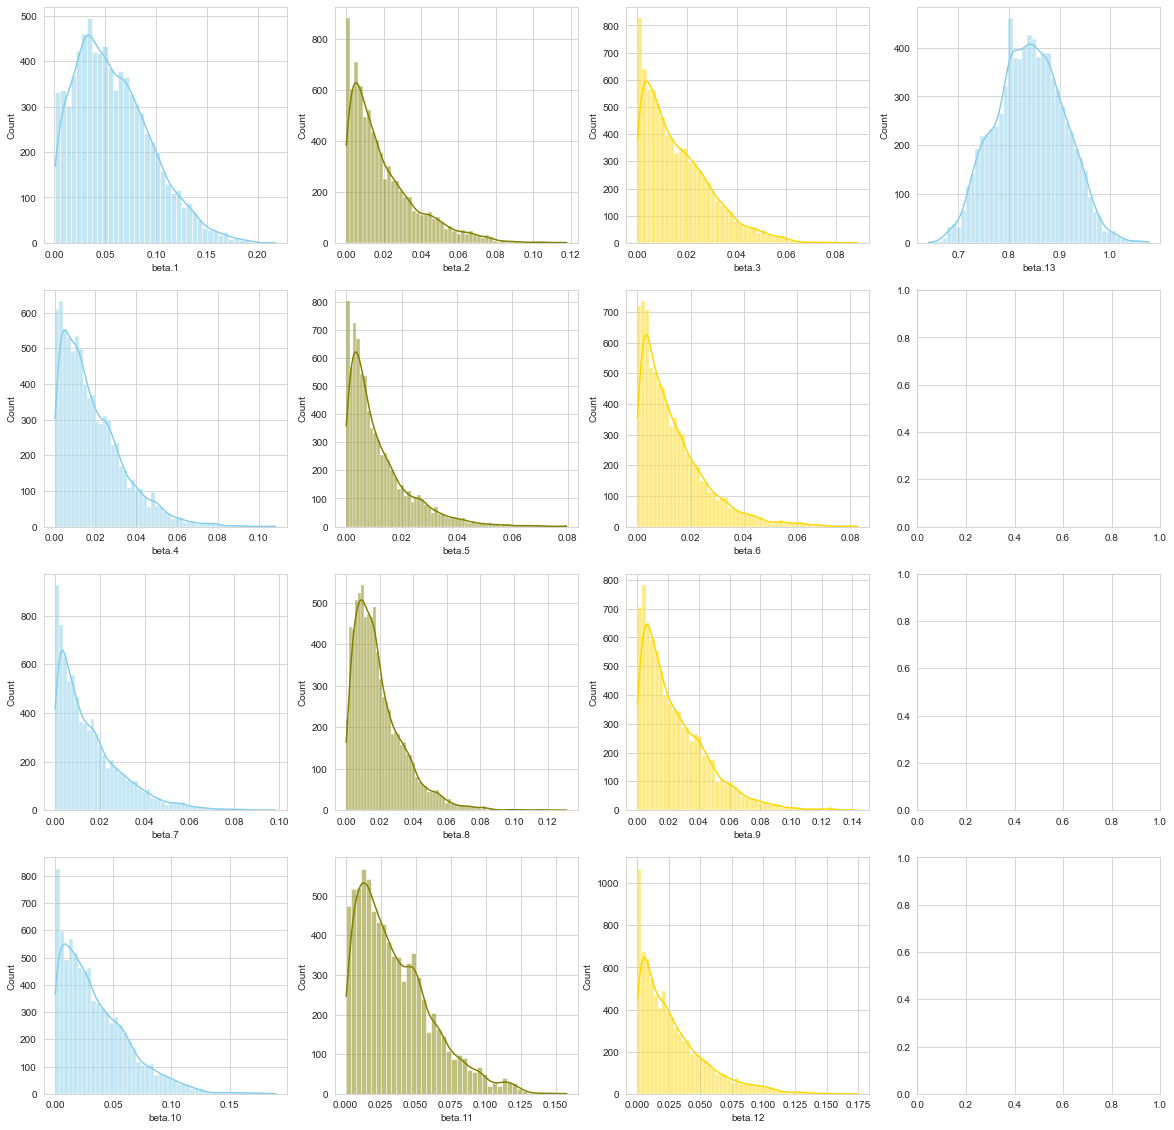

In [83]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

sns.histplot(data=fit2_result, x="beta.1", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=fit2_result, x="beta.2", kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=fit2_result, x="beta.3", kde=True, color="gold", ax=axs[0, 2])
sns.histplot(data=fit2_result, x="beta.4", kde=True, color="skyblue", ax=axs[1, 0])
sns.histplot(data=fit2_result, x="beta.5", kde=True, color="olive", ax=axs[1, 1])
sns.histplot(data=fit2_result, x="beta.6", kde=True, color="gold", ax=axs[1, 2])
sns.histplot(data=fit2_result, x="beta.7", kde=True, color="skyblue", ax=axs[2, 0])
sns.histplot(data=fit2_result, x="beta.8", kde=True, color="olive", ax=axs[2, 1])
sns.histplot(data=fit2_result, x="beta.9", kde=True, color="gold", ax=axs[2, 2])
sns.histplot(data=fit2_result, x="beta.10", kde=True, color="skyblue", ax=axs[3, 0])
sns.histplot(data=fit2_result, x="beta.11", kde=True, color="olive", ax=axs[3, 1])
sns.histplot(data=fit2_result, x="beta.12", kde=True, color="gold", ax=axs[3, 2])
sns.histplot(data=fit2_result, x="beta.13", kde=True, color="skyblue", ax=axs[0, 3])

plt.show()

#len(fit2['beta'])
#len(fit2['beta'][1])

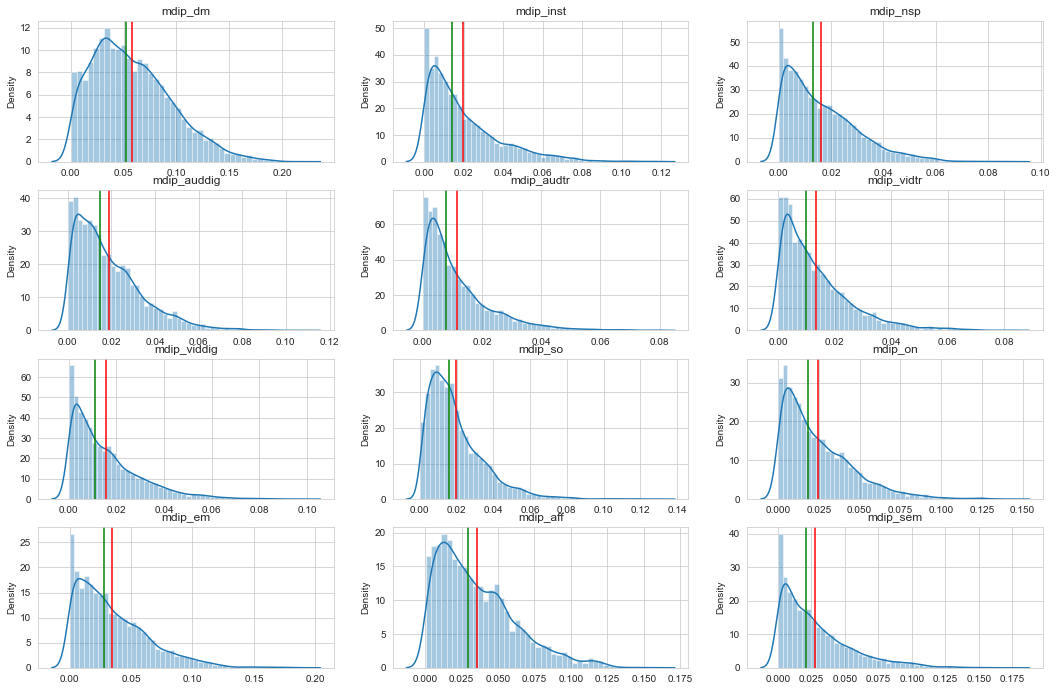

In [137]:
# extract mmm parameters
def extract_mmm(fit_result, max_lag=max_lag, 
                media_vars=mdip_cols, ctrl_vars=['base_sales'], 
                extract_param_list=True):
    mmm = {}
    
    mmm['max_lag'] = max_lag
    mmm['media_vars'], mmm['ctrl_vars'] = media_vars, ctrl_vars
    mmm['decay'] = decay = fit_result['decay'].mean(axis=1).tolist()
    mmm['peak'] = peak = fit_result['peak'].mean(axis=1).tolist()
    mmm['beta'] = fit_result['beta'].mean(axis=1).tolist()
    mmm['tau'] = fit_result['tau'].mean()
    if extract_param_list:
        mmm['decay_list'] = fit_result['decay'].tolist()
        mmm['peak_list'] = fit_result['peak'].tolist()
        mmm['beta_list'] = fit_result['beta'].tolist()
        mmm['tau_list'] = fit_result['tau'].tolist()
    
    adstock_params = {}
    media_names = [col.replace('mdip_', '') for col in media_vars]
    for i in range(len(media_names)):
        adstock_params[media_names[i]] = {
            'L': max_lag,
            'P': peak[i],
            'D': decay[i]
        }
    mmm['adstock_params'] = adstock_params
    return mmm

mmm = extract_mmm(fit2, max_lag=max_lag, 
                media_vars=mdip_cols, ctrl_vars=['base_sales'])
# save_json(mmm, 'mmm1.json')


# plot media coefficients' distributions
# red line: mean, green line: median
beta_media = {}
for i in range(len(mmm['media_vars'])):
    md = mmm['media_vars'][i]
    betas = []
    betas.append(mmm['beta_list'][i])
    beta_media[md] = np.array(betas)

f = plt.figure(figsize=(18,15))
for i in range(len(mmm['media_vars'])):
    ax = f.add_subplot(5,3,i+1)
    md = mmm['media_vars'][i]
    x = beta_media[md]
    mean_x = x.mean()
    median_x = np.median(x)
    ax = sns.distplot(x)
    ax.axvline(mean_x, color='r', linestyle='-')
    ax.axvline(median_x, color='g', linestyle='-')
    ax.set_title(md)
     

In [166]:
media_vars, ctrl_vars = mmm['media_vars'], mmm['ctrl_vars']
num_media, num_ctrl = len(media_vars), len(ctrl_vars)
X_media2 = adstock_transform(df, media_vars, adstock_params)
X_media2, sc_mmm2 = mean_center_trandform(X_media2, media_vars)
np.array(X_media2['mdip_dm'])

array([0.02728877, 0.27276971, 0.96147148, 1.4424965 , 1.07142139,
       1.0002911 , 1.29043741, 1.06652506, 1.09977282, 1.1884966 ,
       1.0833988 , 1.60315831, 2.23498298, 1.61717477, 1.4025268 ,
       1.63755754, 1.57742962, 1.3556538 , 1.96831334, 2.34914908,
       2.04251778, 1.73090029, 1.24093936, 0.71122752, 0.7561826 ,
       1.20281149, 1.07037606, 0.78246971, 0.76479718, 0.82621212,
       0.9721839 , 0.72009279, 0.9803266 , 1.70789202, 2.12542215,
       1.59513182, 0.96590163, 0.91115804, 1.45063043, 1.36016985,
       1.15855613, 1.34502913, 0.94280549, 0.8257585 , 1.33566994,
       1.26695876, 1.07282643, 1.24955318, 0.7960051 , 0.63826108,
       1.20188038, 1.30991521, 0.72901283, 0.63013052, 0.85032027,
       0.87003277, 0.99858542, 1.31873596, 1.28662909, 1.50392267,
       1.74220345, 1.61069904, 1.29884156, 0.80780569, 0.84229194,
       1.16810089, 1.08467725, 1.75496858, 2.24895162, 1.71436875,
       1.55363899, 1.51325256, 2.22165778, 2.16433671, 1.56356

In [138]:
# Decompose sales to media channels' contribution
# Each media channel's contribution = total sales - sales upon removal the channel    

# decompose sales to media contribution
def mmm_decompose_contrib(mmm, df, original_sales=df['sales']):
    # adstock params
    adstock_params = mmm['adstock_params']
    # coefficients, intercept
    beta, tau = mmm['beta'], mmm['tau']
    # variables
    media_vars, ctrl_vars = mmm['media_vars'], mmm['ctrl_vars']
    num_media, num_ctrl = len(media_vars), len(ctrl_vars)
    # X_media2: adstocked, mean-centered media variables + 1
    X_media2 = adstock_transform(df, media_vars, adstock_params)
    X_media2, sc_mmm2 = mean_center_trandform(X_media2, media_vars)
    X_media2 = X_media2 + 1
    # X_ctrl2, mean-centered control variables + 1
    X_ctrl2, sc_mmm2_1 = mean_center_trandform(df[ctrl_vars], ctrl_vars)
    X_ctrl2 = X_ctrl2 + 1
    # y_true2, mean-centered sales variable + 1
    y_true2, sc_mmm2_2 = mean_center_trandform(df, ['sales'])
    y_true2 = y_true2 + 1
    sc_mmm2.update(sc_mmm2_1)
    sc_mmm2.update(sc_mmm2_2)
    # X2 <- media variables + ctrl variable
    X2 = pd.concat([X_media2, X_ctrl2], axis=1)

    # 1. compute each media/control factor: 
    # log-log model: log(sales) = log(X[0])*beta[0] + ... + log(X[13])*beta[13] + tau
    # multiplicative model: sales = X[0]^beta[0] * ... * X[13]^beta[13] * e^tau
    # each factor = X[i]^beta[i]
    # intercept = e^tau
    factor_df = pd.DataFrame(columns=media_vars+ctrl_vars+['intercept'])
    for i in range(num_media):
        colname = media_vars[i]
        factor_df[colname] = X2[colname] ** beta[i]
    for i in range(num_ctrl):
        colname = ctrl_vars[i]
        factor_df[colname] = X2[colname] ** beta[num_media+i]
    factor_df['intercept'] = np.exp(tau)

    # 2. calculate the product of all factors -> y_pred
    # baseline = intercept * control factor = e^tau * X[13]^beta[13]
    y_pred = factor_df.apply(np.prod, axis=1)
    factor_df['y_pred'], factor_df['y_true2'] = y_pred, y_true2
    factor_df['baseline'] = factor_df[['intercept']+ctrl_vars].apply(np.prod, axis=1)

    # 3. calculate each media factor's contribution
    # media contribution = total volume – volume upon removal of the media factor
    mc_df = pd.DataFrame(columns=media_vars+['baseline'])
    for col in media_vars:
        mc_df[col] = factor_df['y_true2'] - factor_df['y_true2']/factor_df[col]
    mc_df['baseline'] = factor_df['baseline']
    mc_df['y_true2'] = factor_df['y_true2']

    # 4. scale contribution
    # predicted total media contribution: product of all media factors
    mc_df['mc_pred'] = mc_df[media_vars].apply(np.sum, axis=1)
    # true total media contribution: total volume - baseline
    mc_df['mc_true'] = mc_df['y_true2'] - mc_df['baseline']
    # predicted total media contribution is slightly different from true total media contribution
    # scale each media factor’s contribution by removing the delta volume proportionally
    mc_df['mc_delta'] =  mc_df['mc_pred'] - mc_df['mc_true']
    for col in media_vars:
        mc_df[col] = mc_df[col] - mc_df['mc_delta']*mc_df[col]/mc_df['mc_pred']

    # 5. scale mc_df based on original sales
    mc_df['sales'] = original_sales
    for col in media_vars+['baseline']:
        mc_df[col] = mc_df[col]*mc_df['sales']/mc_df['y_true2']
    
    print('rmse (log-log model): ', 
         mean_squared_error(np.log(y_true2), np.log(y_pred)) ** (1/2))
    print('mape (multiplicative model): ', 
         mean_absolute_percentage_error(y_true2, y_pred))
    return mc_df

# calculate media contribution percentage
def calc_media_contrib_pct(mc_df, media_vars=mdip_cols, sales_col='sales', period=52):
    '''
    returns:
    mc_pct: percentage over total sales
    mc_pct2: percentage over incremental sales (sales contributed by media channels)
    '''
    mc_pct = {}
    mc_pct2 = {}
    s = 0
    if period is None:
        for col in (media_vars+['baseline']):
            mc_pct[col] = (mc_df[col]/mc_df[sales_col]).mean()
    else:
        for col in (media_vars+['baseline']):
            mc_pct[col] = (mc_df[col]/mc_df[sales_col])[-period:].mean()
    for m in media_vars:
        s += mc_pct[m]
    for m in media_vars:
        mc_pct2[m] = mc_pct[m]/s
    return mc_pct, mc_pct2

mc_df = mmm_decompose_contrib(mmm, df, original_sales=df['sales'])
adstock_params = mmm['adstock_params']
mc_pct, mc_pct2 = calc_media_contrib_pct(mc_df, period=52)
# mc_df.to_csv('mc_df1.csv', index=False)
# save_json(adstock_params, 'adstock_params1.json')
# pd.concat([
#     pd.DataFrame.from_dict(mc_pct, orient='index', columns=['mc_pct']),
#     pd.DataFrame.from_dict(mc_pct2, orient='index', columns=['mc_pct2'])
# ], axis=1).to_csv('mc_pct_df1.csv')


rmse (log-log model):  0.12726087069319011
mape (multiplicative model):  20.45198745080094


In [144]:
mc_df.to_csv('mc_df1.csv', index=False)

In [139]:
mc_pct2

{'mdip_dm': 0.14909176013450445,
 'mdip_inst': 0.04997323304712998,
 'mdip_nsp': 0.008329957582319409,
 'mdip_auddig': 0.0935683776472778,
 'mdip_audtr': 0.04350742893255534,
 'mdip_vidtr': 0.04395946828881018,
 'mdip_viddig': 0.05141909242608367,
 'mdip_so': 0.09157989543510005,
 'mdip_on': 0.0876723073323658,
 'mdip_em': 0.1416226184793632,
 'mdip_aff': 0.13032346142883913,
 'mdip_sem': 0.108952399265651}

In [146]:
mc_pct

{'mdip_dm': 0.024694963634749736,
 'mdip_inst': 0.00827736671494391,
 'mdip_nsp': 0.0013797409017695164,
 'mdip_auddig': 0.015498292335387721,
 'mdip_audtr': 0.00720639674762455,
 'mdip_vidtr': 0.00728127074102377,
 'mdip_viddig': 0.008516853087309567,
 'mdip_so': 0.015168928084313247,
 'mdip_on': 0.014521690798969332,
 'mdip_em': 0.02345780484481993,
 'mdip_aff': 0.021586257602944952,
 'mdip_sem': 0.018046440228196774,
 'baseline': 0.8343639942779467}

In [140]:
# 2.3 Diminishing Return Model    
def create_hill_model_data(df, mc_df, adstock_params, media):
    y = mc_df['mdip_'+media].values
    L, P, D = adstock_params[media]['L'], adstock_params[media]['P'], adstock_params[media]['D']
    x = df['mdsp_'+media].values
    x_adstocked = apply_adstock(x, L, P, D)
    # centralize
    mu_x, mu_y = x_adstocked.mean(), y.mean()
    sc = {'x': mu_x, 'y': mu_y}
    x = x_adstocked/mu_x
    y = y/mu_y
        
    model_data = {
        'N': len(y),
        'y': y,
        'X': x
    }
    return model_data, sc

model_code3 = '''
functions {
  // the Hill function
  real Hill(real t, real ec, real slope) {
  return 1 / (1 + (t / ec)^(-slope));
  }
}

data {
  // the total number of observations
  int N;
  // y: vector of media contribution
  vector[N] y;
  // X: vector of adstocked media spending
  vector[N] X;
}

parameters {
  // residual variance
  real noise_var;
  // regression coefficient
  real beta_hill;
  // ec50 and slope for Hill function of the media
  real ec;
  real slope;
}

transformed parameters {
  // a vector of the mean response
  vector[N] mu;
  for (i in 1:N) {
    mu[i] <- beta_hill * Hill(X[i], ec, slope);
  }
}

model {
  slope ~ gamma(3, 1);
  ec ~ beta(2, 2);
  beta_hill ~ normal(0, 1);
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01); 
  y ~ normal(mu, sqrt(noise_var));
}
'''

# pipeline for training one hill model for a media channel
def train_hill_model(df, mc_df, adstock_params, media, sm):
    '''
    params:
    df: original data
    mc_df: media contribution df derived from MMM
    adstock_params: adstock parameter dict output by MMM
    media: 'dm', 'inst', 'nsp', 'auddig', 'audtr', 'vidtr', 'viddig', 'so', 'on', 'sem'
    sm: stan model object    
    returns:
    a dict of model data, scaler, parameters
    '''
    data, sc = create_hill_model_data(df, mc_df, adstock_params, media)
    fit = sm.sample(num_chains=4, num_samples=2000)
    fit_result = fit.to_frame()
    hill_model = {
        'beta_hill_list': fit_result['beta_hill'].tolist(),
        'ec_list': fit_result['ec'].tolist(),
        'slope_list': fit_result['slope'].tolist(),
        'sc': sc,
        'data': {
            'X': data['X'].tolist(),
            'y': data['y'].tolist(),
        }
    }
    return hill_model

# extract params by mean or median
# almost no difference, choose either one
def extract_hill_model_params(hill_model, method='mean'):
    if method=='mean':
        hill_model_params = {
            'beta_hill': np.mean(hill_model['beta_hill_list']), 
            'ec': np.mean(hill_model['ec_list']), 
            'slope': np.mean(hill_model['slope_list'])
        }
    elif method=='median':
        hill_model_params = {
            'beta_hill': np.median(hill_model['beta_hill_list']), 
            'ec': np.median(hill_model['ec_list']), 
            'slope': np.median(hill_model['slope_list'])
        }
    return hill_model_params

def hill_model_predict(hill_model_params, x):
    beta_hill, ec, slope = hill_model_params['beta_hill'], hill_model_params['ec'], hill_model_params['slope']
    y_pred = beta_hill * hill_transform(x, ec, slope)
    return y_pred

def evaluate_hill_model(hill_model, hill_model_params):
    x = np.asarray(hill_model['data']['X'])
    y_true = np.asarray(hill_model['data']['y']) * hill_model['sc']['y']
    y_pred = hill_model_predict(hill_model_params, x) * hill_model['sc']['y']
    print('mape on original data: ', 
         mean_absolute_percentage_error(y_true, y_pred))
    return y_true, y_pred



In [ ]:
#df.head()
#mc_df, adstock_params, media
#mc_df.head()
#adstock_params
#media


In [141]:
# train hill models for all media channels
#sm3 = stan.build(model_code3)
hill_models = {}
to_train = ['dm', 'inst', 'nsp', 'auddig', 'audtr', 'vidtr', 'viddig', 'so', 'on', 'sem']
for media in to_train:
    print('training for media: ', media)
    model_data, sc = create_hill_model_data(df, mc_df, adstock_params, media)
    sm3 = stan.build(model_code3, data=model_data)
    hill_model = train_hill_model(df, mc_df, adstock_params, media, sm3)
    print("trained for media: ", media)
    hill_models[media] = hill_model

# extract params by mean
hill_model_params_mean, hill_model_params_med = {}, {}
for md in list(hill_models.keys()):
    print("extracting " + md)
    hill_model = hill_models[md]
    params1 = extract_hill_model_params(hill_model, method='mean')
    params1['sc'] = hill_model['sc']
    hill_model_params_mean[md] = params1
#     params2 = extract_hill_model_params(hill_model, method='median')
#     params2['sc'] = hill_model['sc']
#     hill_model_params_med[md] = params2
# save_json(hill_model_params_med, 'hill_model_params_med.json')
# save_json(hill_model_params_mean, 'hill_model_params_mean.json')

# evaluate model params extracted by mean
for md in list(hill_models.keys()):
    print('evaluating media: ', md)
    hill_model = hill_models[md]
    hill_model_params = hill_model_params_mean[md]
    _ = evaluate_hill_model(hill_model, hill_model_params)
# evaluate model params extracted by median
# for md in list(hill_models.keys()):
#     print('evaluating media: ', md)
#     hill_model = hill_models[md]
#     hill_model_params = hill_model_params_med[md]
#     _ = evaluate_hill_model(hill_model, hill_model_params)


Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_hq7fmt0j/model_ky7j2p6k.stan', line 32, column 10: assignment
    operator <- is deprecated in the Stan language and will be removed in
    Stan 2.32.0; use = instead. This can be done automatically with the
    canonicalize flag for stanc
Warning in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_hq7fmt0j/model_ky7j2p6k.stan', line 40, column 30: Argument
    0.0005 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_hq7fmt0j/model_ky7j2p6k.stan', line 40, column 24: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_hq7fmt0j/model_ky7j2p6k.stan', li

training for media:  dm


Sampling:   0%
Sampling:   4% (500/12000)
Sampling:  29% (3500/12000)
Sampling:  54% (6500/12000)
Sampling:  61% (7300/12000)
Sampling:  82% (9800/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 0.00047 seconds
  1000 transitions using 10 leapfrog steps per transition would take 4.7 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -8.13906, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.08195, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00939, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.05473, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.10651, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0141, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -5.39527, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03394, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00618, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00124, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00484, but must be in the in

  Exception: beta_lpdf: Random variable is 1.11845, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.06761, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-co

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01465, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.07007, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.08013, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -4.99592, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrice

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -0.112893, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00412, but must be in the inter

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -1.56323, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -0.737328, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, 

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01512, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -0.66748, but must be positiv

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.29016, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.45955, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.40474, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.18575, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02107, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00132, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04523, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00497, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01192, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02536, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -3.70277, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.08705, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrice

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03216, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00301, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01733, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04358, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  Exception: gamma_lpdf: Random variable is -1.80748, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: gamma_lpdf: Random variable is -0.0442167, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: gamma_lpdf: Random variable is -1.27579, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: gamma_lpdf: Random variable is -0.274887, but must be positive finite! (in '/var/folders

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -74.3515, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.449277, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to colum

  Exception: beta_lpdf: Random variable is -0.00111855, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.0030725, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.10069, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03714, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.05994, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02498, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.28809, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.054, but must be in the inte

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01458, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -5.31381, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrice

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00064, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01894, but must be in the in

trained for media:  dm
training for media:  inst


Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 0.001279 seconds
  1000 transitions using 10 leapfrog steps per transition would take 12.79 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -8.13045, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejec

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.617406, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.06217, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column

  Exception: beta_lpdf: Random variable is 1.0883, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0081, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-cond

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04096, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00102, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 1

  Exception: beta_lpdf: Random variable is 1.00387, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01515, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-co

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01349, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01026, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04218, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02695, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01036, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0502, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00646, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01726, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01374, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.06516, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01673, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -5.42356, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrice

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03343, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00667, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01867, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00259, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02637, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01889, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00026, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02451, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00293, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02358, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00051, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04318, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03369, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02917, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00603, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01278, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00238, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00345, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01739, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00644, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.16014, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00749, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0014, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01021, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01269, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00297, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00222, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.4834, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.38522, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00902, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00014, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00732, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03354, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03752, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.07027, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0073, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00141, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00476, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.10547, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02719, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.983313, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0022, but must be in the i

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00624, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03411, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.05952, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00792, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01104, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01239, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02568, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02253, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03059, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02254, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00046, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02228, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00502, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0031, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -1.33155, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 8.19849, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrice

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.05392, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02546, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00847, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00813, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00713, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0214, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02015, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02888, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0049, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00324, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04028, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00605, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00354, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01031, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00565, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00558, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00458, but must be in the interval

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.11864, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02793, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01305, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00881, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01291, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04455, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00661, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00876, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01555, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02622, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00583, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.013, but must be in the inte

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03159, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00182, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -0.178174, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02266, but must be in the inter

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.029, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00835, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matri

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0216, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01119, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.05106, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -0.287096, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matric

  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: beta_lpdf: Random variable is 1.97939, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: gamma_lpdf: Random variable is -1.80748, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: gamma_lpdf: Random variable is -0.0442167, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Excep

  Exception: beta_lpdf: Random variable is -2455.4, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -70.6564, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-c

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -2.72629e-05, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.000352551, but must be

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.00295759, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.00108339, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covari

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.0563106, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00173, but must be in the

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01087, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 7.1126, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.07081, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.3426, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04283, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01334, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.05066, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.09438, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01152, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.06213, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -3.03538, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04499, but must be in the i

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00586, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01688, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0088, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00121, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00666, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02833, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.021, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01524, but must be in the inte

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02618, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00738, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01135, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02747, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00202, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00528, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01575, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00302, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02956, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -0.438808, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matric

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0121, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0227, but must be in the inte

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0025, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01931, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02181, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00424, but must be in the in

trained for media:  inst
training for media:  nsp


Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -13.0184, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejecte

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.06556, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.80736, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 1

  Exception: beta_lpdf: Random variable is 1.01042, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01864, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-co

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00699, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0269, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18

  Exception: beta_lpdf: Random variable is 1.01432, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02637, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-co

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00554, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00807, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 1

  Exception: beta_lpdf: Random variable is 1.03012, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.06724, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-co

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04826, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.14006, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 1

  Exception: beta_lpdf: Random variable is 1.0075, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00623, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-con

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01048, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00017, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 1

  Exception: beta_lpdf: Random variable is 1.02676, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00999, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-co

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03627, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03237, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 1

  Exception: beta_lpdf: Random variable is -0.432074, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03921, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02381, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01121, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -1.911, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00833, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02177, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00577, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00337, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00048, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02243, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00918, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04397, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0028, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01443, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03284, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00476, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02678, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00598, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.06006, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0308, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00026, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02256, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.08072, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 1

  Exception: beta_lpdf: Random variable is -1.80562, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02225, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-c

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.14394, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.13936, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 6.40009, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01975, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.06104, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.285373, but must be in the 

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00131, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00519, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01618, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -1.21612, but must be in the i

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00421, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03157, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.14282, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00245, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01856, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.559042, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance m

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01438, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.60776, but must be in the i

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01368, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01345, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04955, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00839, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01931, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.05907, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04303, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00007, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02836, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -1.36543, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance ma

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00818, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00108, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02835, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00138, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01831, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00107, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03802, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02482, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04064, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03602, but must be in the in

  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: gamma_lpdf: Random variable is -0.22915, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: beta_lpdf: Random variable is 1.3598, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: beta_lpdf: Random variable is -0.112014, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Ex

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0795, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.35416, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0607, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01826, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00325, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.07429, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.2184, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02007, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0243, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -2.07133, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -2.39103, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -0.122665, but must be posit

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.09215, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03814, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01058, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.22063, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01657, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00885, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04976, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.07314, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.09588, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01111, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04888, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04844, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01808, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00587, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02985, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.07805, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02384, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0275, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01876, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01619, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00058, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00058, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01055, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02921, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01183, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.535016, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance m

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02918, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00409, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0035, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01257, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02896, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0068, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00425, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00226, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01237, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01099, but must be in the in

  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: beta_lpdf: Random variable is 1.72507, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: beta_lpdf: Random variable is 1.18542, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: beta_lpdf: Random variable is 1.71937, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
 

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.638485, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -1772.68, but must be in the

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04192, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04355, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02358, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -2.72331, but must be in the i

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03552, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00517, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.18943, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00787, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.06291, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00462, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -9.48871, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00567, but must be in the interv

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00885, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.06869, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00007, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03126, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.05695, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.06385, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.840579, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02367, but must be in the 

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0849, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00481, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00481, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00108, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02329, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0559, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00281, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03392, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0085, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01384, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04504, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0421, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00025, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02244, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00644, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01895, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00169, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00001, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02199, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02147, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0097, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03203, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04102, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00169, but must be in the in

trained for media:  nsp
training for media:  auddig


Sampling:   5% (600/12000)
Sampling:  11% (1300/12000)
Sampling:  17% (2000/12000)
Sampling:  22% (2600/12000)
Sampling:  42% (5000/12000)
Sampling:  61% (7300/12000)
Sampling:  80% (9600/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -8.62109, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely i

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.30939, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.48406, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.17953, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00589, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00271, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -3.62272, but must be positiv

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.08442, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02265, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00022, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00013, but must be in the in

  Exception: beta_lpdf: Random variable is 1.03203, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.27107, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-co

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.10339, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -1.96027, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
 

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.8272, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -0.570413, but must be positiv

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.76354, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -0.143919, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matric

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00433, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0267, but must be in the int

  Gradient evaluation took 5.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -10.4276, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -8.02054, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/

  Exception: beta_lpdf: Random variable is 1.25044, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.53826, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-co

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.33857, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.13864, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 1

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00209, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04125, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -0.119894, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0651, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrice

  Exception: gamma_lpdf: Random variable is -1.80748, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: gamma_lpdf: Random variable is -0.0442167, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: gamma_lpdf: Random variable is -1.27579, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: gamma_lpdf: Random variable is -0.274887, but must be positive finite! (in '/var/folders

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -77.9785, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.484584, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to colum

  Exception: beta_lpdf: Random variable is -5.18409e-05, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.000309793, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either sever

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.20675, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.12223, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.76328, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.69835, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.19867, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.24817, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00436, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00815, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

trained for media:  auddig
training for media:  audtr


Sampling:   4% (500/12000)
Sampling:  10% (1200/12000)
Sampling:  35% (4200/12000)
Sampling:  38% (4600/12000)
Sampling:  59% (7100/12000)
Sampling:  78% (9400/12000)
Sampling:  82% (9800/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -7.84841, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -1.50678, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -6.946, but must be positive

  Exception: gamma_lpdf: Random variable is -0.0507316, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -0.443751, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditi

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -0.17546, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00946, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
 

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00583, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01335, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -1.58847, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -0.402169, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, 

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -1.28107, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: gamma_lpdf: Random variable is -0.0261686, but must be positive finite! (in '/var/folde

  Exception: beta_lpdf: Random variable is 1.18005, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.185425, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.00230761, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -0.126835, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -2.96826, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.103019, but must be in the inte

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02777, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.87261, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -0.00918948, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -0.21758, but must be positive

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01133, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -0.0434673, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matri

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -0.975367, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 6.88862, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matric

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.83405, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -1.8057, but must be positiv

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.26588, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -0.100914, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matric

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -0.055355, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -1.67134, but must be positive f

  Exception: gamma_lpdf: Random variable is -0.414072, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -0.507962, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditio

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01684, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00068, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 1

  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: beta_lpdf: Random variable is 1.58018, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: gamma_lpdf: Random variable is -1.06581, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: gamma_lpdf: Random variable is -1.38895, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Excepti

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.0409535, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.00227908, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to c

  Exception: beta_lpdf: Random variable is -0.0025793, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.00249842, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.000111848, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.000192091, but must be

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.000219729, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.000444422, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like cova

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.00298477, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.00172048, but must be i

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -6.97233e-05, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.000556296, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like cova

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.00043981, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.000174327, but must be 

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.250751, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.25658, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance m

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.19353, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.38981, but must be in the in

  Exception: beta_lpdf: Random variable is 1.01148, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.07686, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-co

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -1.2552, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00822, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0152, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01994, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.0318345, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0093, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance m

trained for media:  audtr
training for media:  vidtr


Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling:  75% (9001/12000)
Sampling:  78% (9300/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -9.38003, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03882, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.512612, but must be in the 

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00492, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00405, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.06605, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.025, but must be in the inte

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0641, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03591, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02129, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.06987, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03769, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.495673, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance m

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.0315497, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00318, but must be in the

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.12304, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.14886, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01793, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00472, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03419, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03688, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02895, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03296, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00588, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00478, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02244, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02562, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03116, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01178, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03508, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.287248, but must be in the 

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01565, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01069, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03387, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04705, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02556, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00711, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 9.03681, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.05756, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 1

  Exception: beta_lpdf: Random variable is 1.02529, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.07609, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-co

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.84094, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 3.19878, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02017, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.17334, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0485, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00742, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -0.823363, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01098, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matric

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00142, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02128, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02627, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.05261, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.55783, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02652, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -1.71433, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.0560729, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is nan, but must be positive! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 41, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.10813, but must be in the interval [0, 1] (

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02172, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00664, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00669, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01148, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.07457, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00235, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00595, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.05605, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00075, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03623, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01618, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01996, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00045, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00709, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02734, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00267, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.05839, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03744, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: beta_lpdf: Random variable is -0.0736909, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: gamma_lpdf: Random variable is -1.41679, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: gamma_lpdf: Random variable is -1.39575, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transi

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01411, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.1682, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00242, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00852, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02388, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02055, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.1059, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.16196, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.38574, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.16049, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02981, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00413, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00537, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02152, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00736, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01023, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0117, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04409, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0126, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01608, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00433, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00418, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01221, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00203, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00343, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01962, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0302, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -2.19805, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00582, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00937, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0123, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00619, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.06474, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00168, but must be in the in

  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: beta_lpdf: Random variable is 1.71937, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: beta_lpdf: Random variable is 1.97939, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: gamma_lpdf: Random variable is -1.80748, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -2558.77, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -73.6089, but must be in the 

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.000427994, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.00124505, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covar

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.08157, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.12767, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.05234, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.18345, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02329, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01091, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.08386, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03415, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0104, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00285, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01279, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01558, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.1132, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02196, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00929, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02659, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0037, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03074, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00178, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00305, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03737, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01149, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0237, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.032, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matric

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00327, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00182, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00751, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00281, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0281, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02875, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02539, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04753, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00201, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03826, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00958, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00431, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

trained for media:  vidtr
training for media:  viddig


Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling:  75% (9001/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 9.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.99 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -9.13724, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis pro

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.2712, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.4955, but must be in the inte

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.19948, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.0968644, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance 

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03566, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02916, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01332, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01013, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.14741, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04595, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0202, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00705, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.22589, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04089, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00157, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.363613, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance m

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00696, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0255, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00912, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01116, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02159, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00268, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00162, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01243, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02421, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00345, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0483, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02307, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00405, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00528, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0402, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00386, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04051, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0489, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02745, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01147, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02988, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04275, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0192, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00466, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00088, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01306, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0301, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00839, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04612, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00042, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03645, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00421, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.83605, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04308, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 1

  Exception: beta_lpdf: Random variable is 1.03893, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.08239, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-co

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.40901, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.90682, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 1

  Exception: gamma_lpdf: Random variable is -3.2366, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.05022, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditi

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00393, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03764, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 1

  Exception: beta_lpdf: Random variable is 1.00724, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02298, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-co

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0321, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03603, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00581, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02557, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02298, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0109, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0035, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02425, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00538, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0052, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02109, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00638, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0334, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00261, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00375, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01996, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02307, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02459, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00313, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0301, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01455, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01335, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02106, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00629, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01218, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00599, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00138, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00356, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01294, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02499, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00079, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -0.114316, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matric

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 10.9217, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 2.56224, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.20848, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.0471632, but must be in the

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.22477, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00869, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -2.57321, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.07896, but must be in the i

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01644, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02358, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0134, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04066, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.09521, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.06344, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04523, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02043, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00147, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01401, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04804, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02265, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00479, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00549, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02967, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01314, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.06514, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0077, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00131, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00018, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0028, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01747, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00295, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00174, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00432, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01854, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02437, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01681, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01243, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01313, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: beta_lpdf: Random variable is 1.97939, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: gamma_lpdf: Random variable is -1.80748, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: gamma_lpdf: Random variable is -0.0442167, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Excep

  Exception: beta_lpdf: Random variable is -2207.21, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -63.5676, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.00011773, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.000371886, but must be 

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -6.4521e-05, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.000461009, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covar

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01148, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00149, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.0649359, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.33426, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance 

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.6521, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02118, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00178, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -1.25124, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrice

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00599, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01812, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0195, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01815, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.035917, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00269, but must be in the 

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01774, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00763, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.17147, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04483, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.06527, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.09191, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00298, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00075, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00621, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00811, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00417, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04256, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.08483, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00316, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.05645, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01657, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04006, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04075, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00214, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00313, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03033, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00396, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00899, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01226, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01095, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00112, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01108, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00755, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0048, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02881, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03141, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00321, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00425, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.07033, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

trained for media:  viddig
training for media:  so


Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -11.6196, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejecte

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01568, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.08445, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 1

  Exception: beta_lpdf: Random variable is 1.02151, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.05489, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-co

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02713, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03508, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03374, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.05836, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.05729, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00988, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01621, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.05553, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03855, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02049, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00922, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02566, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.05449, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01493, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02343, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00616, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.198139, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00687, but must be in the 

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04194, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00941, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.29876, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03002, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.44748, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -2.21791, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance ma

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.232867, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02062, but must be in the 

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04202, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.05052, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -0.137494, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.06493, but must be in the inter

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04137, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03737, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03126, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 2.50795, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00783, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02751, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02371, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.05925, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02246, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03272, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01272, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00376, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00205, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00937, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00858, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00613, but must be in the in

  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: gamma_lpdf: Random variable is -1.41679, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: gamma_lpdf: Random variable is -1.39575, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  Gradient evaluation took 8.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.89 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -9.90902, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5

  Exception: beta_lpdf: Random variable is 1.09657, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01924, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-co

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.724007, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04316, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column

  Exception: beta_lpdf: Random variable is 1.0149, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.09845, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-con

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00499, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.05915, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 1

  Exception: beta_lpdf: Random variable is 1.02475, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.17522, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-co

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.23172, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00491, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.10116, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01211, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00719, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00411, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00483, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01447, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00978, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00606, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02528, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01351, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01292, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01457, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00727, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02548, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: beta_lpdf: Random variable is 1.90619, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: beta_lpdf: Random variable is -0.840583, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: gamma_lpdf: Random variable is -1.88793, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  E

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.000773366, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00003, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covarianc

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.09624, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00021, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0084, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.05238, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01727, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0474, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.06403, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.29958, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03233, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -3.07752, but must be positiv

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00241, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04823, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0034, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00014, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00964, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02892, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00222, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01466, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02456, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00697, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00507, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00616, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02592, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00612, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

trained for media:  so
training for media:  on


Sampling:   8% (900/12000)
Sampling:  32% (3900/12000)
Sampling:  58% (6900/12000)
Sampling:  82% (9900/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 0.00074 seconds
  1000 transitions using 10 leapfrog steps per transition would take 7.4 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -8.30884, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis propo

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00412, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.1373, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.44623, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00659, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00963, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -0.756122, but must be positi

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.07749, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00203, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01237, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02099, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00942, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.05565, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01035, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01603, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01073, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -1.01359, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrice

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.1074, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.81796, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.0146546, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01801, but must be in the

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.09316, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01377, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.11016, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.33909, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.91063, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.23474, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0058, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.40305, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01722, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01559, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00157, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01203, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01298, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0069, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01417, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03349, but must be in the in

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 7.81692, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.78603, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.18273, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03754, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03853, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04529, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 2.20836, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03261, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.10078, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00157, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02955, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01345, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.496424, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.50527, but must be in the 

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0009, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01036, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00622, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00864, but must be in the in

  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: beta_lpdf: Random variable is 1.72507, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: beta_lpdf: Random variable is 1.18542, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: beta_lpdf: Random variable is 1.71937, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
 

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.695186, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -2458.42, but must be in the

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.19968, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.07291, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00082, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -0.517354, but must be positi

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.17579, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01604, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.07077, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -0.536359, but must be positi

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.08771, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -0.0312229, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matri

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02267, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0104, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01577, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02555, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02127, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0127, but must be in the int

trained for media:  on
training for media:  sem


Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 5.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -7.71298, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejecte

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.11299, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.13747, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 1

  Exception: beta_lpdf: Random variable is 1.0244, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.36749, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-con

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03044, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00301, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 1

  Exception: beta_lpdf: Random variable is 1.01534, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00276, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-co

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0187, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0408, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)

  Exception: beta_lpdf: Random variable is 1.00129, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02322, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-co

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.13972, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04116, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 1

  Exception: beta_lpdf: Random variable is 1.00301, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00969, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-co

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00339, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03892, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 1

  Exception: beta_lpdf: Random variable is 1.00142, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00318, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-co

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01702, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.06765, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 1

  Exception: beta_lpdf: Random variable is 1.00814, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00687, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-co

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01003, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00307, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 1

  Exception: beta_lpdf: Random variable is 1.00398, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.0243638, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00698, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01814, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01084, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00167, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00402, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02184, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01631, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00363, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02023, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00863, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01042, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00249, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00058, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00905, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01946, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -0.505848, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matric

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.07825, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.12535, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 1

  Exception: beta_lpdf: Random variable is 1.01145, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00042, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-co

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.06906, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.08558, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04576, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00216, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00858, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01604, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01086, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01188, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.14644, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00285, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -0.0132074, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01931, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matri

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00733, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0083, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00898, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0178, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00287, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01726, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02891, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01313, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02829, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0316, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.17603, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00374, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00275, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00267, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0276, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03845, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00201, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01806, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01709, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00462, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02619, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0591, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00334, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01886, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00093, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.523751, but must be in the 

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02622, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00063, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01573, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01212, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01088, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0063, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0246, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00499, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00991, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02283, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00354, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03417, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0001, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00757, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01922, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00451, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00969, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01655, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.592497, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00803, but must be in the 

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02481, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00003, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 2.45135, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02553, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0091, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.38263, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0044, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.1303, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matri

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00026, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.07212, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00496, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.12808, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04192, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.06038, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.09124, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -0.0586268, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matri

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02534, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03569, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03581, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00183, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01074, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -1.12916, but must be in the i

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01626, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.05185, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00549, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01344, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00261, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00256, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00069, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01289, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00134, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00786, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0032, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02681, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00547, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00129, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00685, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00306, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00244, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02075, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01308, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01234, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00443, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00396, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00596, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00308, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00661, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00243, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: beta_lpdf: Random variable is 1.18542, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: beta_lpdf: Random variable is 1.71937, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: beta_lpdf: Random variable is 1.97939, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
 

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.684588, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -2520.66, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance 

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.00140291, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -0.00119307, but must be i

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01674, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0135, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03194, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00237, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.04396, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.91241, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0009, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.19141, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00541, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00491, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.23151, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01433, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -2.45794, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.09144, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrice

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00263, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0094, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01268, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00407, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is -0.295708, but must be positive finite! (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 37, column 2 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00408, but must be in the inter

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00862, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00754, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01356, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is -1.01476, but must be in the i

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03884, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.37869, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00781, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00426, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01226, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.06383, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02522, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01312, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00917, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02673, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.03332, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0019, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00224, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01935, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00951, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01513, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00616, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.06288, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0156, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00836, but must be in the int

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0126, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02766, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.003, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00461, but must be in the inte

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0033, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02759, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00672, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00725, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.0189, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01314, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matr

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.02016, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00224, but must be in the in

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.01896, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Random variable is 1.00011, but must be in the interval [0, 1] (in '/var/folders/9z/4_t0jkrj0072fbyb_w5_63h40000gn/T/httpstan_boptn8yq/model_ky7j2p6k.stan', line 38, column 2 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance mat

trained for media:  sem
extracting dm
extracting inst
extracting nsp
extracting auddig
extracting audtr
extracting vidtr
extracting viddig
extracting so
extracting on
extracting sem
evaluating media:  dm
mape on original data:  377.88220196802683
evaluating media:  inst
mape on original data:  421.2763233597015
evaluating media:  nsp
mape on original data:  344.71993005008534
evaluating media:  auddig
mape on original data:  394.34945244717807
evaluating media:  audtr
mape on original data:  442.22580088022215
evaluating media:  vidtr
mape on original data:  394.6394781404963
evaluating media:  viddig
mape on original data:  412.1504359936323
evaluating media:  so
mape on original data:  nan
evaluating media:  on
mape on original data:  470.77885619473096
evaluating media:  sem
mape on original data:  409.44997812223835


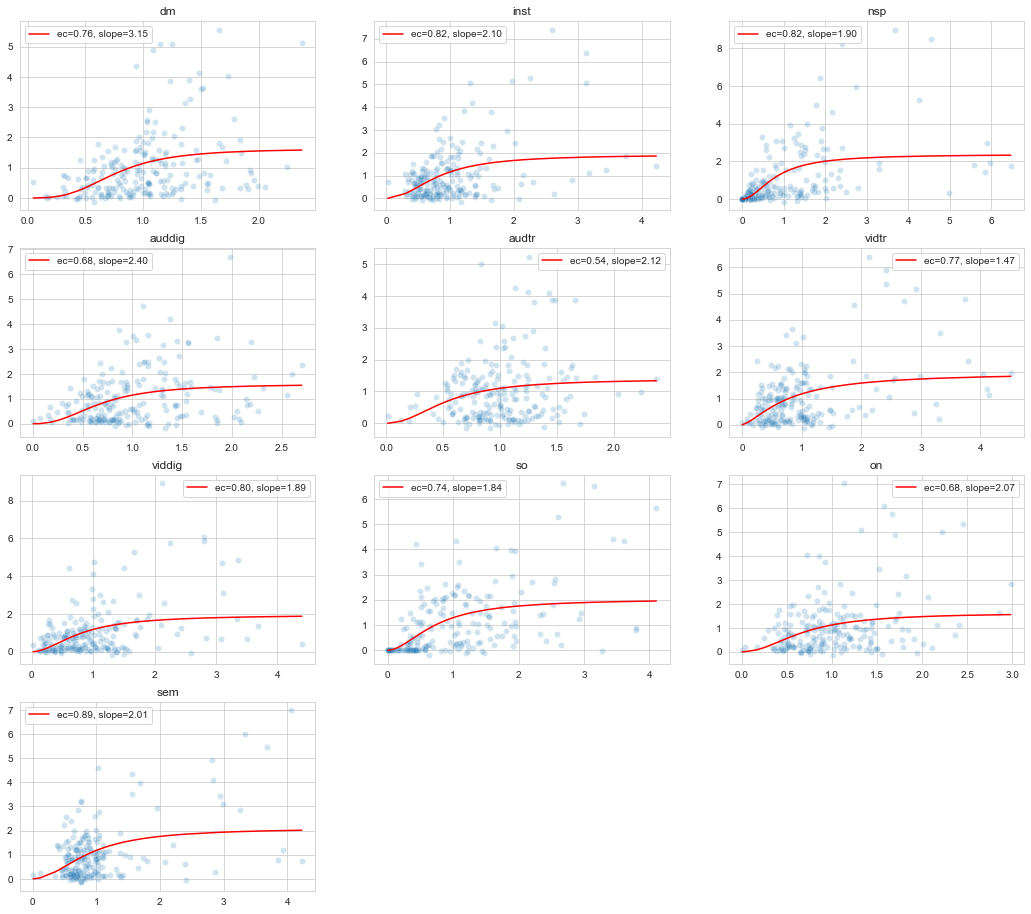

In [142]:
# plot fitted hill function
f = plt.figure(figsize=(18,16))
hm_keys = list(hill_models.keys())
for i in range(len(hm_keys)):
    ax = f.add_subplot(4,3,i+1)
    md = hm_keys[i]
    hm = hill_models[md]
    hmp = hill_model_params_mean[md]
    x, y = hm['data']['X'], hm['data']['y']
    #mu_x, mu_y = hm['sc']['x'], hm['sc']['y']
    ec, slope = hmp['ec'], hmp['slope']
    x_sorted = np.array(sorted(x))
    y_fit = hill_model_predict(hmp, x_sorted)
    ax = sns.scatterplot(x=x, y=y, alpha=0.2)
    ax = sns.lineplot(x=x_sorted, y=y_fit, color='r', 
                 label='ec=%.2f, slope=%.2f'%(ec, slope))
    ax.set_title(md)



roas_mean  roas_median       mroas    roas_avg
dm        5.177214     4.726342    6.848673    5.568985
inst     20.975248    20.072282   23.076816   20.892262
nsp       4.535251     2.642422    5.779168    5.557711
auddig  367.940275   305.528229  124.466419  351.434610
audtr     7.700224     6.243654    3.346703    7.267637
vidtr     8.938178     7.063913    3.807688    6.732692
viddig   49.548410    54.355739   36.361392   54.143671
so       11.346863     9.888383    4.375965   10.965553
on        6.819271     5.912251    3.776220    6.596123
sem       3.384023     2.989632    2.774724    3.252051

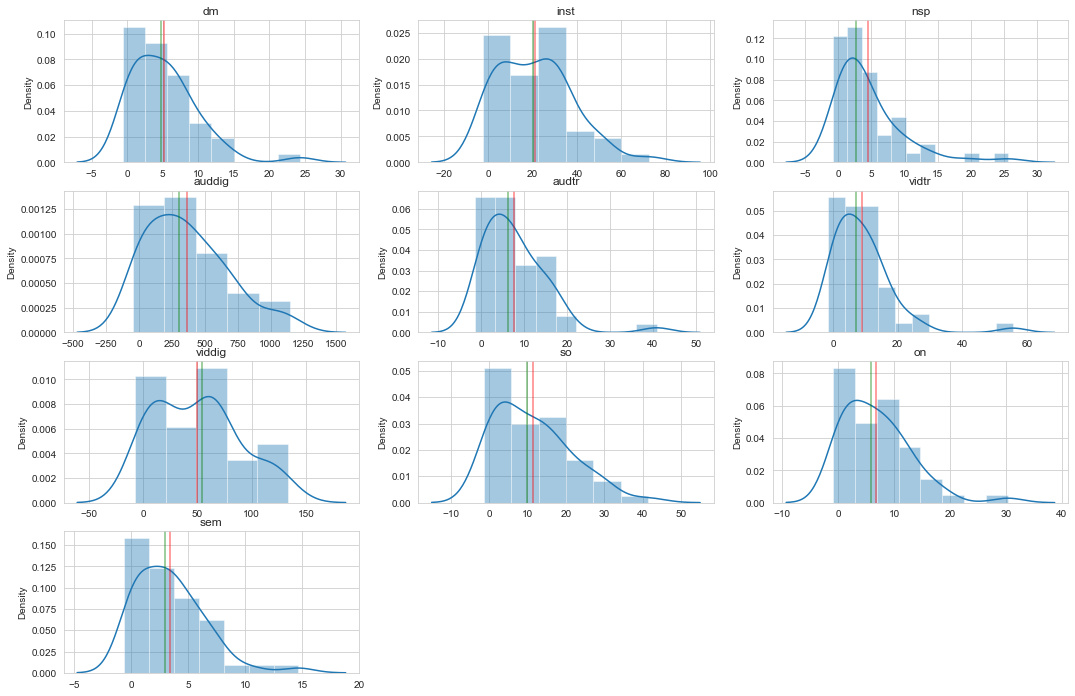

In [143]:
# Calculate overall ROAS and weekly ROAS
# - Overall ROAS = total contribution / total spending
# - Weekly ROAS = weekly contribution / weekly spending

# adstocked media spending
ms_df = pd.DataFrame()
for md in list(hill_models.keys()):
    hill_model = hill_models[md]
    x = np.array(hill_model['data']['X']) * hill_model['sc']['x']
    ms_df['mdsp_'+md] = x
# ms_df.to_csv('ms_df1.csv', index=False)

# calc overall ROAS of a given period
def calc_roas(mc_df, ms_df, period=None):
    roas = {}
    md_names = [col.split('_')[-1] for col in ms_df.columns]
    for i in range(len(md_names)):
        md = md_names[i]
        sp, mc = ms_df['mdsp_'+md], mc_df['mdip_'+md]
        if period is None:
            md_roas = mc.sum()/sp.sum()
        else:
            md_roas = mc[-period:].sum()/sp[-period:].sum()
        roas[md] = md_roas
    return roas

# calc weekly ROAS
def calc_weekly_roas(mc_df, ms_df):
    weekly_roas = pd.DataFrame()
    md_names = [col.split('_')[-1] for col in ms_df.columns]
    for md in md_names:
        weekly_roas[md] = mc_df['mdip_'+md]/ms_df['mdsp_'+md]
    weekly_roas.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
    return weekly_roas

roas_1y = calc_roas(mc_df, ms_df, period=52)
weekly_roas = calc_weekly_roas(mc_df, ms_df)
roas1y_df = pd.DataFrame(index=weekly_roas.columns.tolist())
roas1y_df['roas_mean'] = weekly_roas[-52:].apply(np.mean, axis=0)
roas1y_df['roas_median'] = weekly_roas[-52:].apply(np.median, axis=0)


# # plot weekly ROAS distribution
# # median: green line, mean: red line
# f = plt.figure(figsize=(18,12))
# for i in range(len(weekly_roas.columns)):
#     md = weekly_roas.columns[i]
#     ax = f.add_subplot(4,3,i+1)
#     x = weekly_roas[md]
#     mean_x = np.mean(x)
#     median_x = np.median(x)
#     ax = sns.distplot(x)
#     ax.axvline(mean_x, color='r', linestyle='-', alpha=0.5)
#     ax.axvline(median_x, color='g', linestyle='-', alpha=0.5)
#     ax.set(xlabel=None)
#     ax.set_title(md)

# plot weekly ROAS distribution of past 1 year
# median: green line, mean: red line
f = plt.figure(figsize=(18,12))
for i in range(len(weekly_roas.columns)):
    md = weekly_roas.columns[i]
    ax = f.add_subplot(4,3,i+1)
    x = weekly_roas[md][-52:]
    mean_x = np.mean(x)
    median_x = np.median(x)
    ax = sns.distplot(x)
    ax.axvline(mean_x, color='r', linestyle='-', alpha=0.5)
    ax.axvline(median_x, color='g', linestyle='-', alpha=0.5)
    ax.set(xlabel=None)
    ax.set_title(md)


# Calculate mROAS
# 1. Current spending level (cur_sp) is represented by mean or median of weekly spending.    
# Next spending level (next_sp) is increasing cur_sp by 1%.
# 2. Plug cur_sp and next_sp into the Hill function:    
# Current media contribution: cur_mc = Hill(cur_sp)    
# Next-level media contribution next_mc = Hill(next_sp)    
# 3. mROAS = (next_mc - cur_mc) / (0.01 * cur_sp)

def calc_mroas(hill_model, hill_model_params, period=52):
    '''
    calculate mROAS for a media
    params:
    hill_model: a dict containing model data and scaling factor
    hill_model_params: a dict containing beta_hill, ec, slope
    period: in weeks, the period used to calculate ROAS and mROAS. 52 is last one year.
    return:
    mROAS value
    '''
    mu_x, mu_y = hill_model['sc']['x'], hill_model['sc']['y']
    # get current media spending level over the period specified
    cur_sp = np.asarray(hill_model['data']['X'])
    if period is not None:
        cur_sp = cur_sp[-period:]
    cur_mc = sum(hill_model_predict(hill_model_params, cur_sp) * mu_y)
    # next spending level: increase by 1%
    next_sp = cur_sp * 1.01
    # media contribution under next spending level
    next_mc = sum(hill_model_predict(hill_model_params, next_sp) * mu_y)
    
    # mROAS
    delta_mc = next_mc - cur_mc
    delta_sp = sum(next_sp * mu_x) - sum(cur_sp * mu_x)
    mroas = delta_mc/delta_sp
    return mroas

# calc mROAS of recent 1 year
mroas_1y = {}
for md in list(hill_models.keys()):
    hill_model = hill_models[md]
    hill_model_params = hill_model_params_mean[md]
    mroas_1y[md] = calc_mroas(hill_model, hill_model_params, period=52)


roas1y_df = pd.concat([
    roas1y_df[['roas_mean', 'roas_median']],
    pd.DataFrame.from_dict(mroas_1y, orient='index', columns=['mroas']),
    pd.DataFrame.from_dict(roas_1y, orient='index', columns=['roas_avg'])
], axis=1)
# roas1y_df.to_csv('roas1y_df1.csv')

roas1y_df
# **ROAS & mROAS**    
# 'roas_avg': overall ROAS = total contribution / total spending    
# 'roas_mean': mean of weekly ROAS    
# 'roas_median': median of weekly ROAS    
# 'mroas': mROAS calculated based on increasing current spending level by 1%   
